In [400]:
# Bloque 1: Importar librerías
import yfinance as yf
import pandas as pd
import ta
import numpy as np
import datetime as dt

In [401]:
# Función optimizada para obtener datos
def get_stock_data(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    data.columns = data.columns.droplevel(1)
    data.reset_index(inplace=True)
    data.rename(columns={"Datetime": "Date"}, inplace=True)

    # Convertir y extraer características de fecha
    data["Date"] = pd.to_datetime(data["Date"])
    data["Day"] = data["Date"].dt.day
    data["Month"] = data["Date"].dt.month
    data["Hour"] = data["Date"].dt.hour
    data["Year"] = data["Date"].dt.year
    data["Dia_de_la_Semana"] = data["Date"].dt.weekday
    data["Dia_del_Año"] = data["Date"].dt.dayofyear

    # Asignar 1 si el cierre es mayor que el cierre anterior (verde), 0 si es menor o igual (rojo)
    data["Volumen_Color_Num"] = (data["Close"] > data["Close"].shift(7)).astype(int)

    return data

ticker = "NKE"
period = "730d"  # Últimos 60 días
interval = "1h"  # Datos por hora

data_2w = get_stock_data(ticker, period, interval)

data_2w.head(-1)

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Day,Month,Hour,Year,Dia_de_la_Semana,Dia_del_Año,Volumen_Color_Num
0,2022-05-13 13:30:00+00:00,111.944000,112.279999,108.669998,109.839996,2942106,13,5,13,2022,4,133,0
1,2022-05-13 14:30:00+00:00,112.165001,112.430000,111.455002,111.959999,593009,13,5,14,2022,4,133,0
2,2022-05-13 15:30:00+00:00,112.065002,112.595001,111.510002,112.190002,707473,13,5,15,2022,4,133,0
3,2022-05-13 16:30:00+00:00,112.089996,112.599998,111.973999,112.110001,748462,13,5,16,2022,4,133,0
4,2022-05-13 17:30:00+00:00,111.589996,112.470001,111.430000,112.099998,859626,13,5,17,2022,4,133,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5080,2025-04-10 14:30:00+00:00,53.269901,54.430000,53.160000,53.974998,7053573,10,4,14,2025,3,100,1
5081,2025-04-10 15:30:00+00:00,52.562099,53.400002,52.380001,53.275002,6256985,10,4,15,2025,3,100,0
5082,2025-04-10 16:30:00+00:00,52.549999,53.540001,52.279999,52.560001,5773172,10,4,16,2025,3,100,0
5083,2025-04-10 17:30:00+00:00,54.305000,54.430000,52.430000,52.555000,7163059,10,4,17,2025,3,100,0


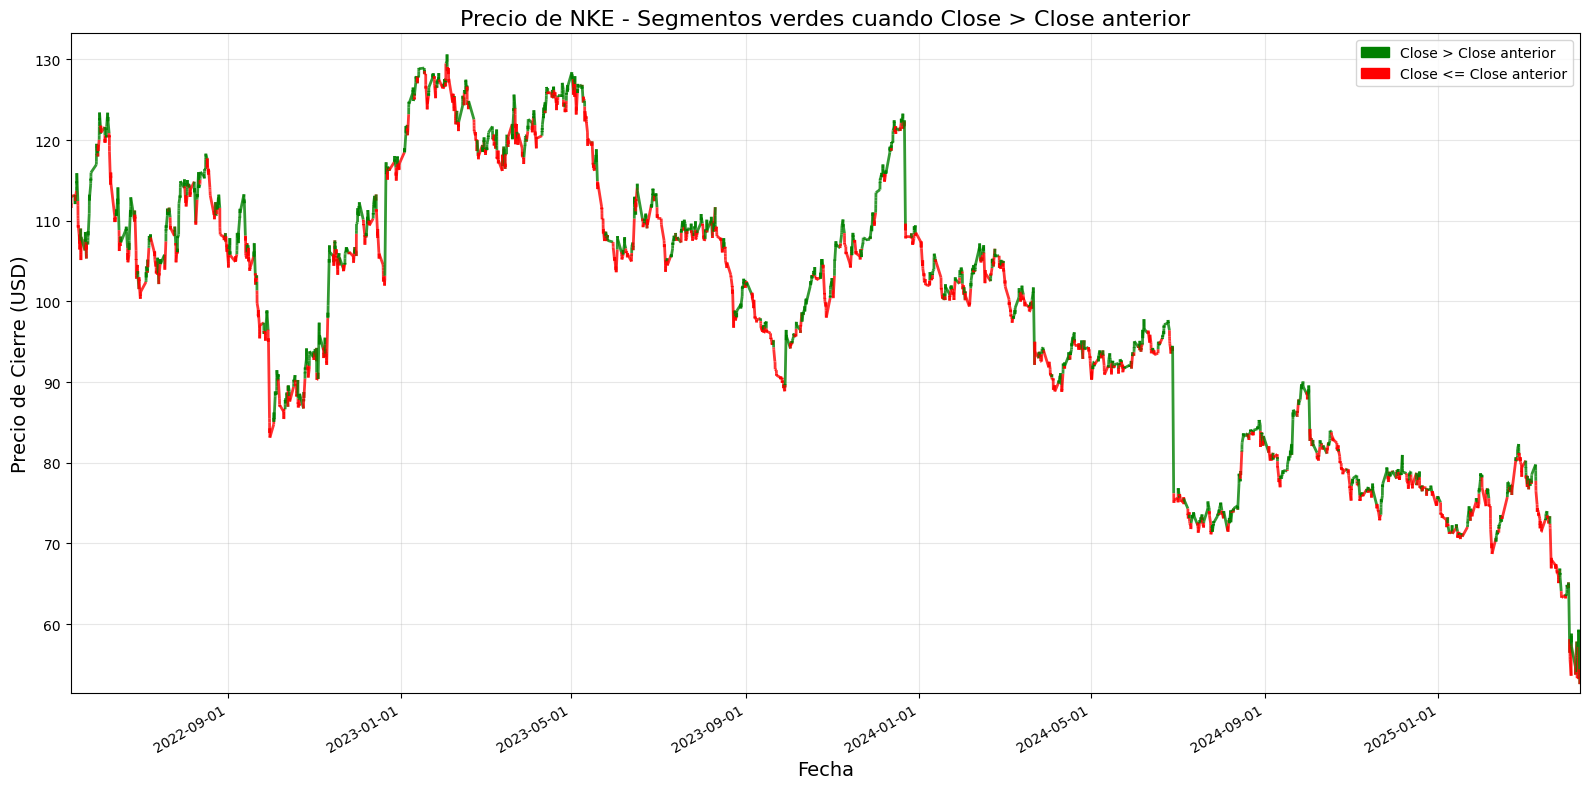

In [402]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection

# Configurar el tamaño del gráfico
plt.figure(figsize=(16, 8))

# Preparar los datos para segmentos coloreados
dates = mdates.date2num(data_2w['Date'])
points = np.array([dates, data_2w['Close']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Crear un mapa de colores para los segmentos (verde cuando Volumen_Color_Num=1, gris cuando=0)
colors = ['green' if val == 1 else 'red' for val in data_2w['Volumen_Color_Num'][:-1]]

# Crear la colección de líneas
lc = LineCollection(segments, colors=colors, linewidth=2, alpha=0.8)

# Configurar el gráfico
plt.gca().add_collection(lc)
plt.xlim(data_2w['Date'].min(), data_2w['Date'].max())
plt.ylim(data_2w['Close'].min()*0.98, data_2w['Close'].max()*1.02)

# Configurar título y etiquetas
plt.title(f'Precio de {ticker} - Segmentos verdes cuando Close > Close anterior', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio de Cierre (USD)', fontsize=14)

# Formatear el eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

# Crear leyenda
green_patch = mpatches.Patch(color='green', label='Close > Close anterior')
gray_patch = mpatches.Patch(color='red', label='Close <= Close anterior')
plt.legend(handles=[green_patch, gray_patch])

# Mostrar cuadrícula
plt.grid(True, alpha=0.3)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [403]:
def calculate_indicators(data):
    # ===================== 📌 MEDIAS MÓVILES =====================
    data["EMA12"] = data["Close"].ewm(span=12, adjust=False).mean()
    data["EMA26"] = data["Close"].ewm(span=26, adjust=False).mean()
    data["EMA50"] = data["Close"].ewm(span=50, adjust=False).mean()
    data["SMA50"] = data["Close"].rolling(window=50).mean()

    # ===================== 🔥 BOLLINGER BANDS =====================
    data["BB_upper"] = (data["Close"].rolling(window=20).mean()+ 2 * data["Close"].rolling(window=20).std())
    data["BB_lower"] = (data["Close"].rolling(window=20).mean()- 2 * data["Close"].rolling(window=20).std())
    data["BBW"] = (data["BB_upper"] - data["BB_lower"]) / data["Close"]  # Ancho de BB

    # ===================== 📊 VOLUMEN =====================
    data["Volume_MA"] = data["Volume"].rolling(window=20).mean()
    data["Vol_Ratio_10h"] = data["Volume"] / data["Volume"].rolling(window=10).mean()

    # ===================== 🔄 CAMBIOS PORCENTUALES =====================
    data["Hourly_Return"] = data["Close"].pct_change() * 100
    data["Cumulative_Return"] = (data["Close"].pct_change(periods=5) * 100)  # Cambio acumulado en 5 horas

    # ===================== 📈 MACD =====================
    data["MACD"] = data["EMA12"] - data["EMA26"]
    data["MACD_Signal"] = data["MACD"].ewm(span=9, adjust=False).mean()

    # ===================== 📊 RSI =====================
    data["RSI"] = ta.momentum.rsi(data["Close"], window=14)

    # ===================== 📉 ATR =====================
    data["ATR"] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=14)

    # ===================== 📊 ADX (Índice de Dirección Media) =====================
    data["ADX"] = ta.trend.adx(data["High"], data["Low"], data["Close"], window=14)

    # ===================== 🔄 ESTOCÁSTICO =====================
    data["Stoch_K"] = ta.momentum.stoch(data["High"], data["Low"], data["Close"], window=14, smooth_window=3)
    data["Stoch_D"] = ta.momentum.stoch_signal(data["High"], data["Low"], data["Close"], window=14, smooth_window=3)

    # ===================== 🔥 MOMENTUM =====================
    data["MOM"] = ta.momentum.roc(data["Close"], window=10)

    # ===================== 🔎 OBV (On-Balance Volume) =====================
    data["OBV"] = ta.volume.on_balance_volume(data["Close"], data["Volume"])

    # ===================== 💰 CMF (Chaikin Money Flow) =====================
    data["CMF"] = ta.volume.chaikin_money_flow(data["High"], data["Low"], data["Close"], data["Volume"], window=20)

    # Eliminar filas con NaN generadas por indicadores
    data.dropna(inplace=True)

    return data


# Aplicar la función al dataframe
data_2w = calculate_indicators(data_2w)

# Mostrar primeras filas con indicadores
print(data_2w.head())

Price                      Date       Close        High         Low  \
49    2022-05-24 13:30:00+00:00  105.320000  107.260002  104.730003   
50    2022-05-24 14:30:00+00:00  105.974998  106.019997  104.980003   
51    2022-05-24 15:30:00+00:00  107.070000  107.605003  105.610001   
52    2022-05-24 16:30:00+00:00  106.440002  107.199997  106.260002   
53    2022-05-24 17:30:00+00:00  107.099998  107.800003  106.300003   

Price        Open   Volume  Day  Month  Hour  Year  ...      MACD  \
49     107.110001  1279271   24      5    13  2022  ... -0.793905   
50     105.290001   718414   24      5    14  2022  ... -0.844185   
51     105.974998  1105035   24      5    15  2022  ... -0.786607   
52     107.099998   345435   24      5    16  2022  ... -0.782788   
53     106.410004   439483   24      5    17  2022  ... -0.718226   

Price  MACD_Signal        RSI       ATR        ADX    Stoch_K    Stoch_D  \
49       -0.979917  38.520711  1.521133  20.006113  13.689018  51.821297   
50    

In [404]:
# 📌 Asegurar que 'Date' sea de tipo datetime
data_2w["Date"] = pd.to_datetime(data_2w["Date"])

# 📌 Calcular el cambio de RSI en una semana
data_2w["RSI_change_1w"] = data_2w["RSI"] - data_2w["RSI"].shift(70)
data_2w["RSI_change_2w"] = data_2w["RSI"] - data_2w["RSI"].shift(140)
data_2w["ADX_change_1w"] = data_2w["ADX"] - data_2w["ADX"].shift(70)
data_2w["ADX_change_2w"] = data_2w["ADX"] - data_2w["ADX"].shift(140)
data_2w["Volume_MA_change_1w"] = data_2w["Volume_MA"] - data_2w["Volume_MA"].shift(70)

In [405]:
# ===================== 📌 CAMBIO PORCENTUAL PASADO =====================
data_2w["Past_Change_1d"] = ((data_2w["Close"] - data_2w["Close"].shift(7)) / data_2w["Close"].shift(7) * 100)
data_2w["Past_Change_2d"] = ((data_2w["Close"] - data_2w["Close"].shift(14)) / data_2w["Close"].shift(14) * 100)
data_2w["Past_Change_1w"] = ((data_2w["Close"] - data_2w["Close"].shift(35)) / data_2w["Close"].shift(35) * 100)
data_2w["Past_Change_2w"] = ((data_2w["Close"] - data_2w["Close"].shift(70)) / data_2w["Close"].shift(70) * 100)

data_2w["Past_Change_1m"] = ((data_2w["Close"] - data_2w["Close"].shift(140)) / data_2w["Close"].shift(140) * 100)
data_2w["Past_Change_2m"] = ((data_2w["Close"] - data_2w["Close"].shift(280)) / data_2w["Close"].shift(280) * 100)
data_2w["Past_Change_3m"] = ((data_2w["Close"] - data_2w["Close"].shift(420)) / data_2w["Close"].shift(420) * 100)
data_2w["Past_Change_6m"] = ((data_2w["Close"] - data_2w["Close"].shift(840)) / data_2w["Close"].shift(840) * 100)

# ===================== 📌 CAMBIO PORCENTUAL FUTURO (2 SEMANAS) =====================
data_2w["Future_Change_1w"] = ((data_2w["Close"].shift(-35) - data_2w["Close"]) / data_2w["Close"] * 100)

In [406]:

# ===================== 📌 FUNCIÓN PARAAR CAMBIOS =====================
def classify_change(percentage, percentiles):
    if percentage <= percentiles[0]:
        return 0  # Venta Muy Fuerteelif percentage <= percentiles[1]
    elif percentage <= percentiles[1]:
        return 1  # Venta
    else:
        return 2


# ===================== 📌 CALCULAR PERCENTILES DINÁMICOS =====================
percentiles_1w = np.percentile(data_2w["Past_Change_1w"].dropna(), [25, 75])
percentiles_2w = np.percentile(data_2w["Past_Change_2w"].dropna(), [30, 70])
percentiles_1m = np.percentile(data_2w["Past_Change_1m"].dropna(), [25, 75])
percentiles_2m = np.percentile(data_2w["Past_Change_2m"].dropna(), [35, 75])
percentiles_3m = np.percentile(data_2w["Past_Change_3m"].dropna(), [35, 75])
percentiles_6m = np.percentile(data_2w["Past_Change_6m"].dropna(), [35, 75])

In [407]:
# ===================== 📌 APLICAR CLASIFICACIÓN =====================
data_2w["Past_Class_1w"] = data_2w["Past_Change_1w"].apply(lambda x: classify_change(x, percentiles_1w))
data_2w["Past_Class_2w"] = data_2w["Past_Change_2w"].apply(lambda x: classify_change(x, percentiles_2w))
data_2w["Past_Class_1m"] = data_2w["Past_Change_1m"].apply(lambda x: classify_change(x, percentiles_1m))
data_2w["Past_Class_2m"] = data_2w["Past_Change_2m"].apply(lambda x: classify_change(x, percentiles_2m))
data_2w["Past_Class_3m"] = data_2w["Past_Change_3m"].apply(lambda x: classify_change(x, percentiles_3m))
data_2w["Past_Class_6m"] = data_2w["Past_Change_6m"].apply(lambda x: classify_change(x, percentiles_6m))

data_2w["Future_Class_1w"] = data_2w["Future_Change_1w"].apply(lambda x: classify_change(x, percentiles_1w))

data_2w["Volatility_Spike_VH"] = (data_2w["Past_Change_2w"] <= percentiles_2w[0]).astype(int)
data_2w["Volatility_Spike_H"] = (data_2w["Past_Change_2w"] <= percentiles_2w[1]).astype(int)
data_2w["Volatility_Spike_I"] = (data_2w["Past_Change_2w"] <= percentiles_2w[1]).astype(int)

data_2w["Volatility_Spike_VH_m"] = (data_2w["Past_Change_2m"] <= percentiles_2m[0]).astype(int)
data_2w["Volatility_Spike_H_m"] = (data_2w["Past_Change_2m"] <= percentiles_2m[1]).astype(int)
data_2w["Volatility_Spike_I_m"] = (data_2w["Past_Change_2m"] <= percentiles_2m[1]).astype(int)


# ===================== 📌 MOSTRAR RESULTADOS =====================
print("Percentiles de cambios pasados (2 semanas):", percentiles_2w)

Percentiles de cambios pasados (2 semanas): [-3.61339052  2.42975715]


In [408]:
def mark_previous_hours(data, column_name, percentiles, horas_a_marcar=84):
    # Crear las nuevas columnas e inicializarlas con 0
    data[f"previousd_strongsell"] = 0
    data[f"previousd_strongbuy"] = 0

    # Iterar sobre los datos para marcar las horas previas
    for i in range(horas_a_marcar, len(data)-7):  # Comenzamos desde el índice de horas_a_marcar
        # Verificar si el cambio porcentual pasado cae por debajo del percentil 15 (fuerte caída)
        if data[column_name].iloc[i] <= percentiles[0]:
            # Marcar las horas previas como 1 en 'previousd_strongsell'
            data.loc[data.index[i - horas_a_marcar : i], "previousd_strongsell"] = 1

        # Verificar si el cambio porcentual pasado es mayor que el percentil 58 (subida moderada)
        if data[column_name].iloc[i] >= percentiles[1]:
            # Marcar las horas previas como 1 en 'previousd_buy'
            data.loc[data.index[i - horas_a_marcar : i], "previousd_strongbuy"] = 1

    return data

data_2w = mark_previous_hours(data_2w, "Past_Change_2w", percentiles_2w, 84)

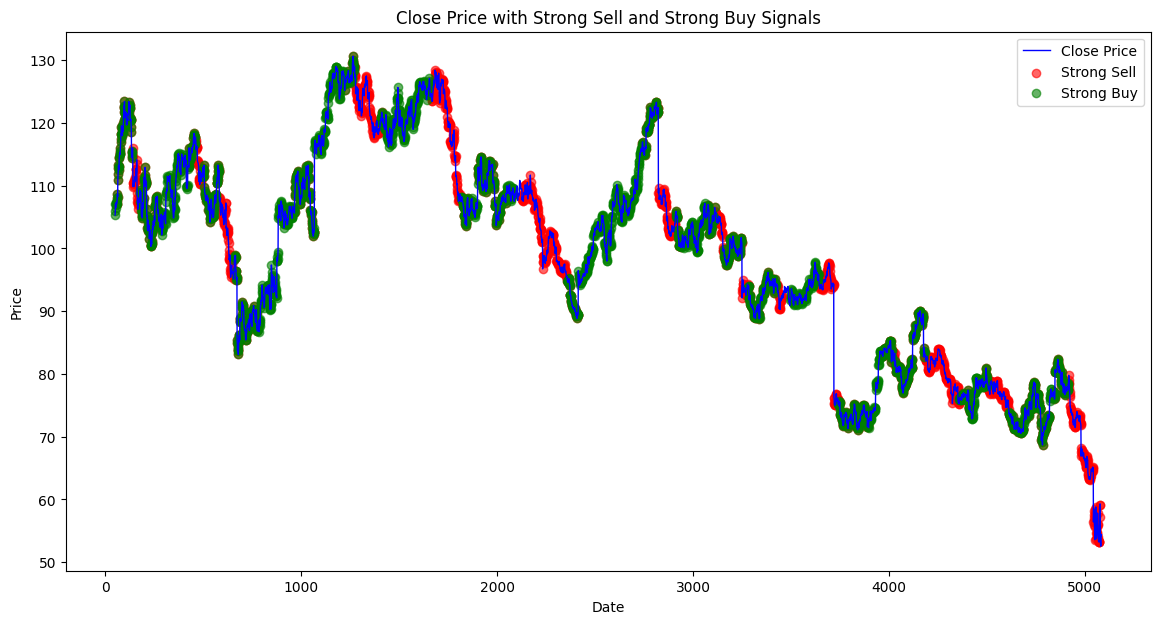

In [409]:
# Graficar 'Close'
plt.figure(figsize=(14, 7))
plt.plot(data_2w['Close'], label='Close Price', color='blue', linewidth=1)

# Marcar los puntos de 'previousd_strongsell' en rojo y 'previousd_strongbuy' en verde
plt.scatter(data_2w.index[data_2w['previousd_strongsell'] == 1], 
            data_2w['Close'][data_2w['previousd_strongsell'] == 1], 
            marker='o', color='red', label='Strong Sell', alpha=0.6)

plt.scatter(data_2w.index[data_2w['previousd_strongbuy'] == 1], 
            data_2w['Close'][data_2w['previousd_strongbuy'] == 1], 
            marker='o', color='green', label='Strong Buy', alpha=0.6)

# Añadir leyenda y títulos
plt.title('Close Price with Strong Sell and Strong Buy Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Mostrar el gráfico
plt.show()


In [410]:
def classify_trend(percentage, percentiles):
    if percentage <= percentiles[0]:  # Por debajo del percentil 25
        return 0  # Tendencia Muy negativa
    elif percentage <= percentiles[1]:  # Entre percentil 25 y 75
        return 1  # Tendencia negativa
    elif percentage <= percentiles[2]:  # Entre percentil 25 y 75
        return 2  # Tendencia neutral
    elif percentage <= percentiles[3]:  # Entre percentil 25 y 75
        return 3  # Tendencia positiva
    else:  # Por encima del percentil 75
        return 4  # Tendencia Muy positiva

percentiles_trend_1w = np.percentile(data_2w["Past_Change_1w"].dropna(), [20,40,60,80])
percentiles_trend_2w = np.percentile(data_2w["Past_Change_2w"].dropna(), [20,40,60,80])
percentiles_trend_1m = np.percentile(data_2w["Past_Change_1m"].dropna(), [20,40,60,80])
percentiles_trend_2m = np.percentile(data_2w["Past_Change_2m"].dropna(), [20,40,60,80])
percentiles_trend_3m = np.percentile(data_2w["Past_Change_3m"].dropna(), [20,40,60,80])
percentiles_trend_6m = np.percentile(data_2w["Past_Change_6m"].dropna(), [20,40,60,80])

In [411]:
def assign_period_trends(data, fecha_col='Date', close_col='Close'):
    # Ordenar por fecha (ascendente)
    data = data.sort_values(fecha_col).copy()
    
    # Definir periodos en términos de número de observaciones
    periods = {
        '6m': 840,
        '3m': 420,
        '2m': 280,
        '1m': 140,
        '2w': 70,
        '1w': 35
    }
    
    # Obtener el número total de registros
    num_data = len(data)
    
    # Para cada periodo, dividir los datos en bloques de tamaño específico
    for period_name, period_size in periods.items():
        trend_col = f'Period_Trend_{period_name}'
        data[trend_col] = np.nan
        
        # Dividir los datos en bloques de tamaño period_size
        for i in range(0, num_data, period_size):
            # Seleccionar los datos en este bloque
            period_data = data.iloc[i:i+period_size]
            
            # Si el bloque tiene al menos dos datos, calcular la tendencia
            if len(period_data) >= 2:
                start_price = period_data[close_col].iloc[0]
                end_price = period_data[close_col].iloc[-1]
                change_pct = ((end_price - start_price) / start_price) * 100
                
                # Clasificar la tendencia (usando percentiles globales)
                if period_name == '1w':
                    trend = classify_trend(change_pct, percentiles_trend_1w)
                elif period_name == '2w':
                    trend = classify_trend(change_pct, percentiles_trend_2w)
                elif period_name == '1m':
                    trend = classify_trend(change_pct, percentiles_trend_1m)
                elif period_name == '2m':
                    trend = classify_trend(change_pct, percentiles_trend_2m)
                elif period_name == '3m':
                    trend = classify_trend(change_pct, percentiles_trend_3m)
                elif period_name == '6m':
                    trend = classify_trend(change_pct, percentiles_trend_6m)
                
                # Asignar la tendencia a todo el bloque
                data.loc[period_data.index, trend_col] = trend
    
    return data

# Aplicar la función
data_2w = assign_period_trends(data_2w)


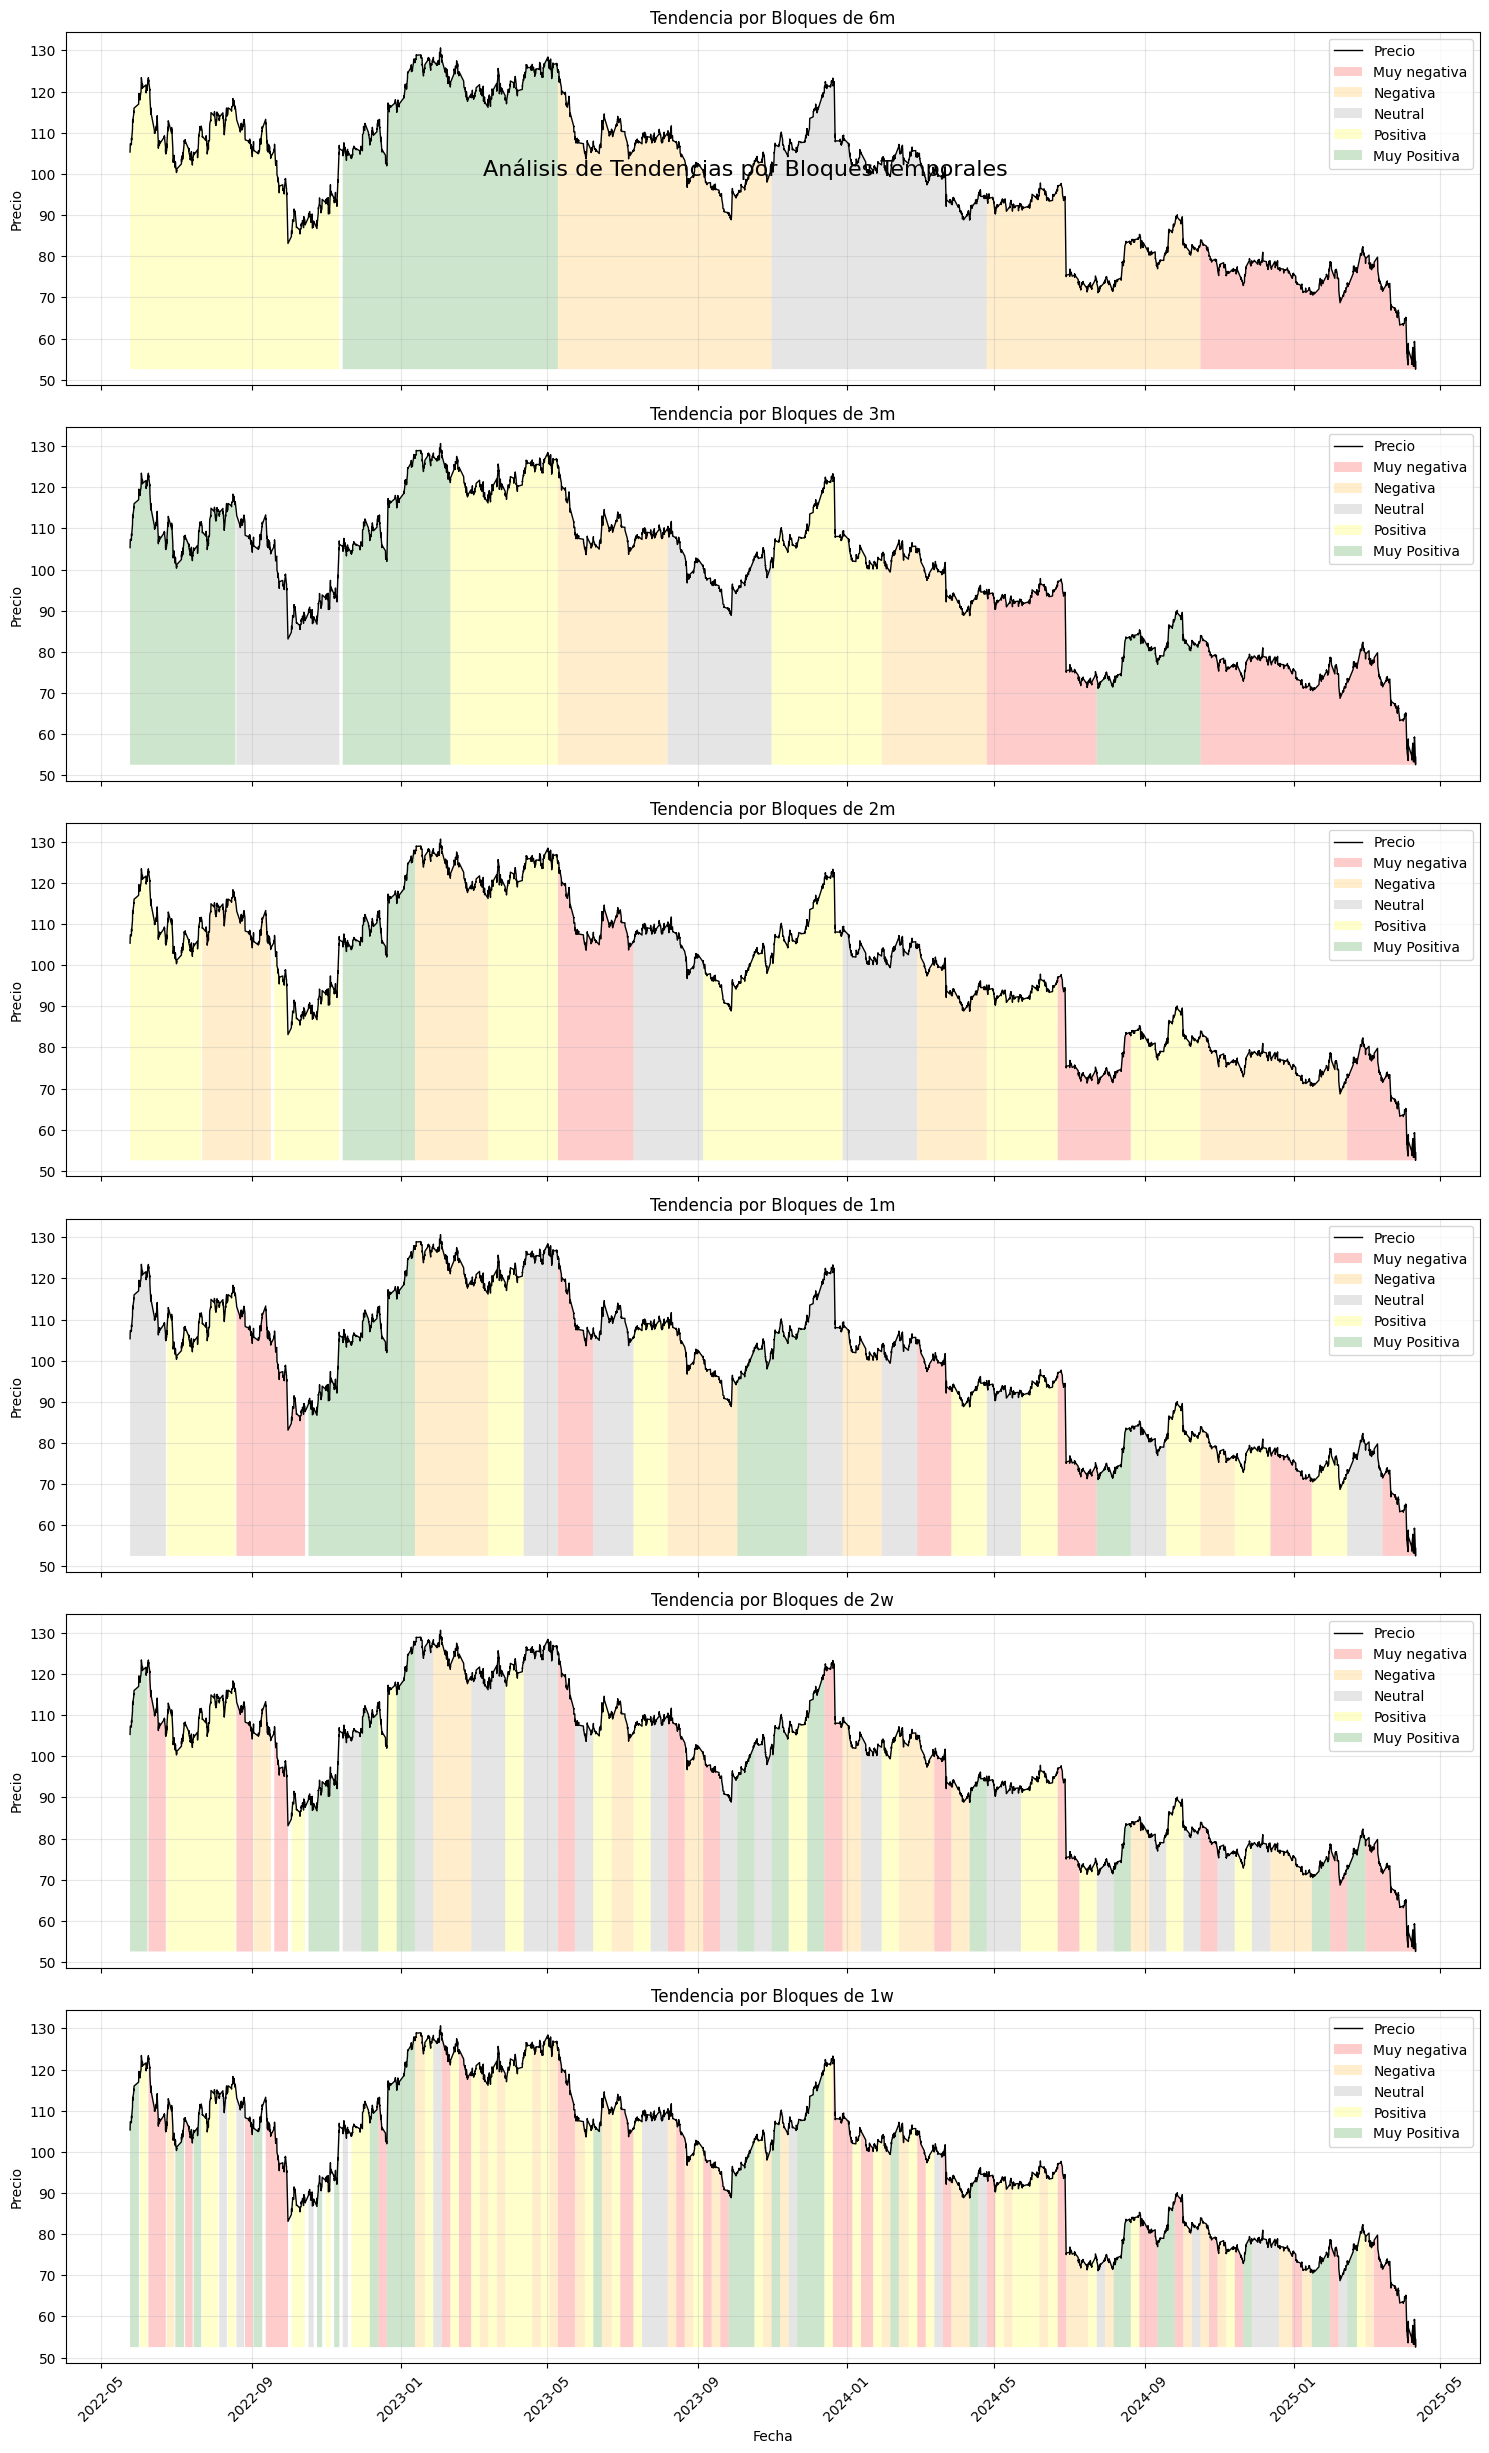

In [412]:
# Definir periodos de forma global
periods = {
    '6m': 840,
    '3m': 420,
    '2m': 280,
    '1m': 140,
    '2w': 70,
    '1w': 36
}

# Llamar a la función con la variable global
data_2w = assign_period_trends(data_2w)

# Crear figura
fig, axes = plt.subplots(len(periods), 1, figsize=(15, 25), sharex=True)

# Graficar cada periodo
for ax, (period_name, _) in zip(axes, periods.items()):
    trend_col = f'Period_Trend_{period_name}'
    
    # Graficar precio
    ax.plot(data_2w['Date'], data_2w['Close'], color='black', linewidth=1, label='Precio')
    
    # Colorear por tendencia
    for trend_val, color in [(0, 'red'), (1, 'orange'), (2, 'gray'), (3, 'yellow'), (4, 'green')]:
        mask = data_2w[trend_col] == trend_val
        ax.fill_between(data_2w['Date'], 
                       data_2w['Close'].min(), 
                       data_2w['Close'],
                       where=mask,
                       facecolor=color,
                       alpha=0.2,
                       label=['Muy negativa','Negativa', 'Neutral','Positiva', 'Muy Positiva'][trend_val])
    
    ax.set_title(f'Tendencia por Bloques de {period_name}', fontsize=12)
    ax.set_ylabel('Precio')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.xlabel('Fecha')
plt.suptitle('Análisis de Tendencias por Bloques Temporales', fontsize=16, y=0.92)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [413]:
from scipy.signal import argrelextrema

def mark_multi_window_trade_signals(data, windows=[14,21,35, 70, 140, 420]):
    """
    Detecta picos importantes en diferentes escalas de tiempo.
    - windows: Lista con los diferentes períodos a analizar.
    """
    data = data.copy()
    
    for window in windows:
        # Crear nuevas columnas para cada ventana
        buy_col = f"buy_signal_w{window}"
        sell_col = f"sell_signal_w{window}"
        data[buy_col] = 0
        data[sell_col] = 0

        # Encontrar mínimos y máximos locales en la ventana dada
        min_indexes = argrelextrema(data["Close"].values, np.less, order=window)[0]  # V normales (comprar)
        max_indexes = argrelextrema(data["Close"].values, np.greater, order=window)[0]  # V invertidas (vender)

        # Marcar picos con margen de ±1 día
        for i in min_indexes:
            data.loc[data.index[max(0, i - 1) : min(len(data), i + 2)], buy_col] = 1
        for i in max_indexes:
            data.loc[data.index[max(0, i - 1) : min(len(data), i + 2)], sell_col] = 1

    return data

# Aplicar la función a los datos
data_2w = mark_multi_window_trade_signals(data_2w, windows=[14,21,35, 70, 140, 420])

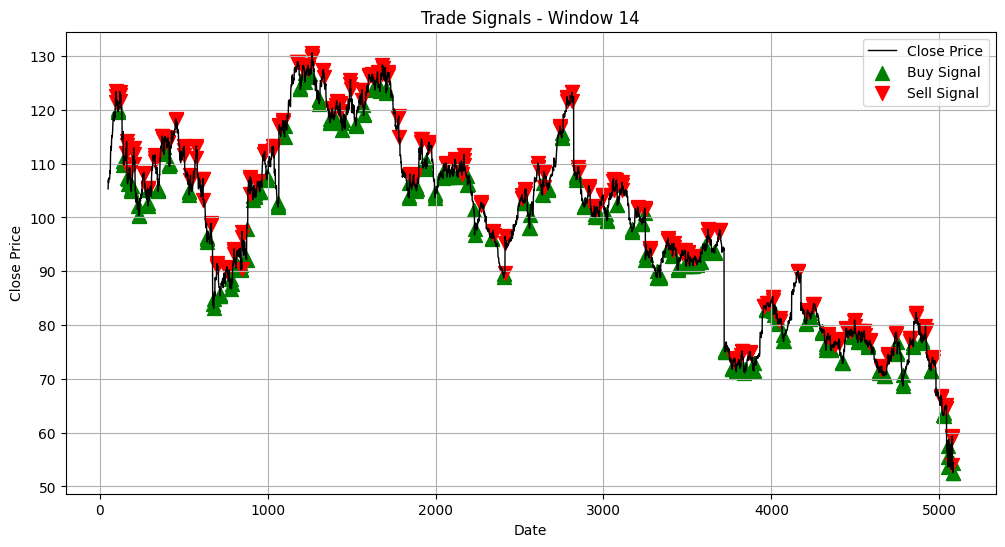

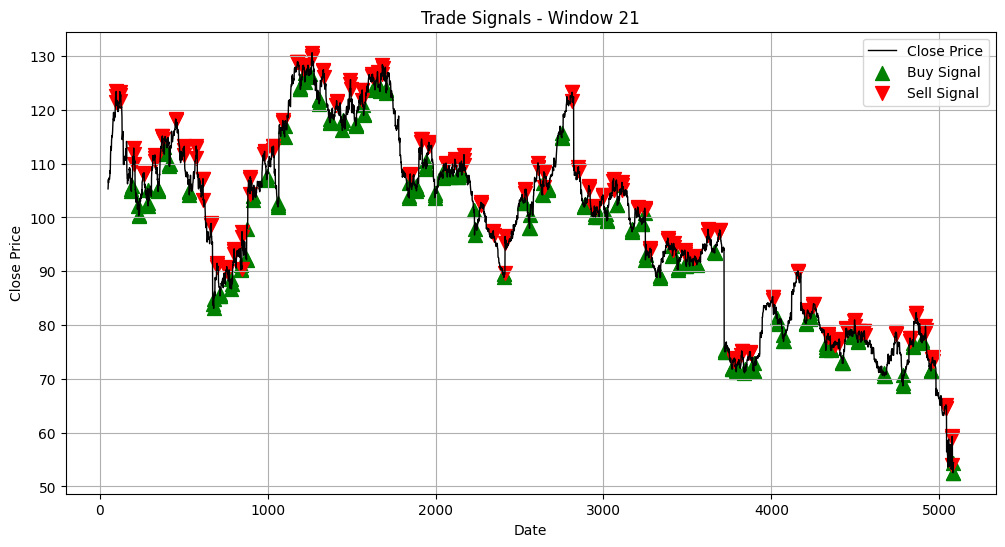

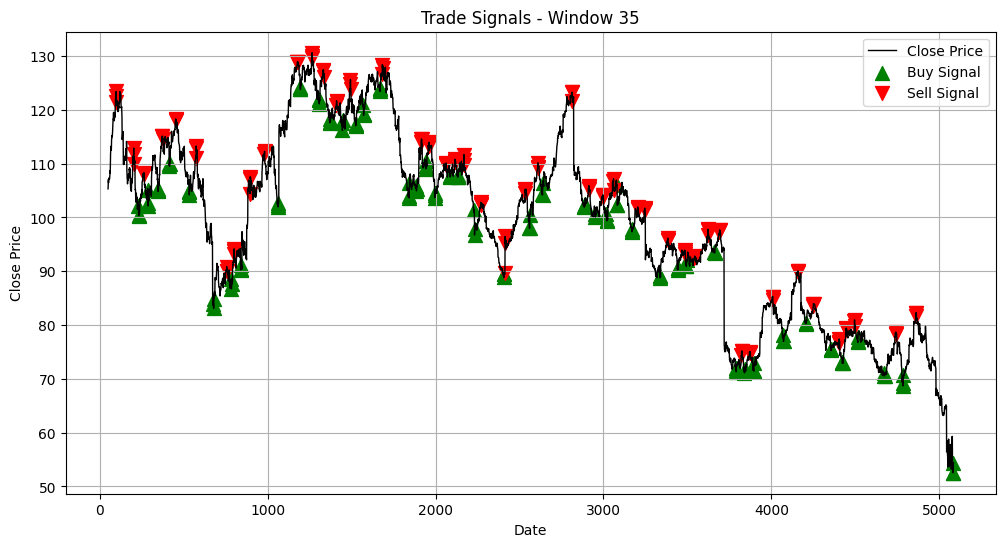

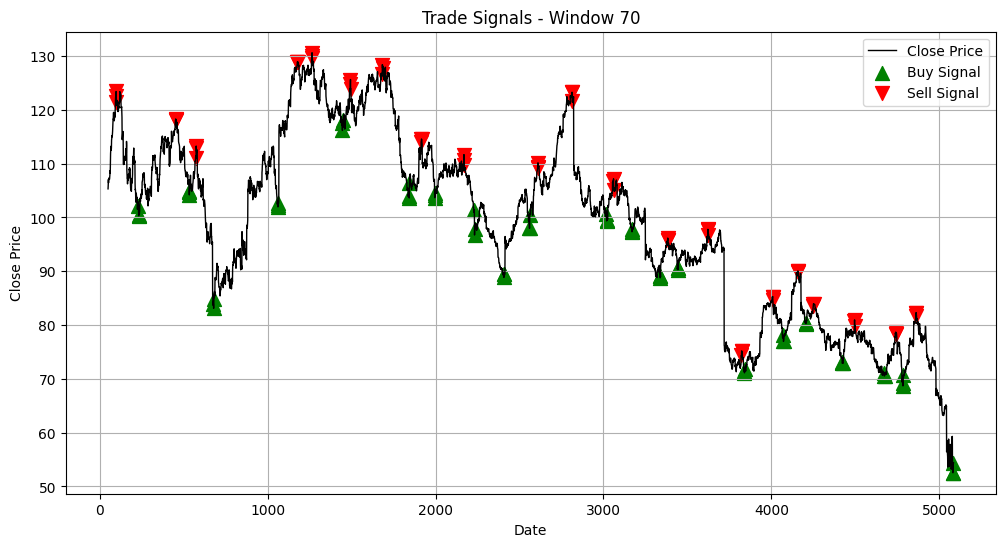

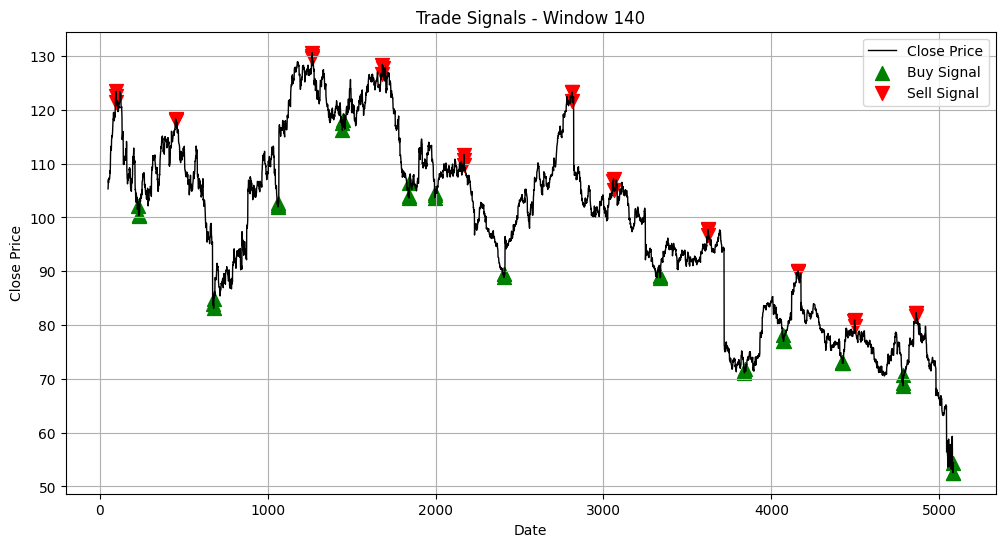

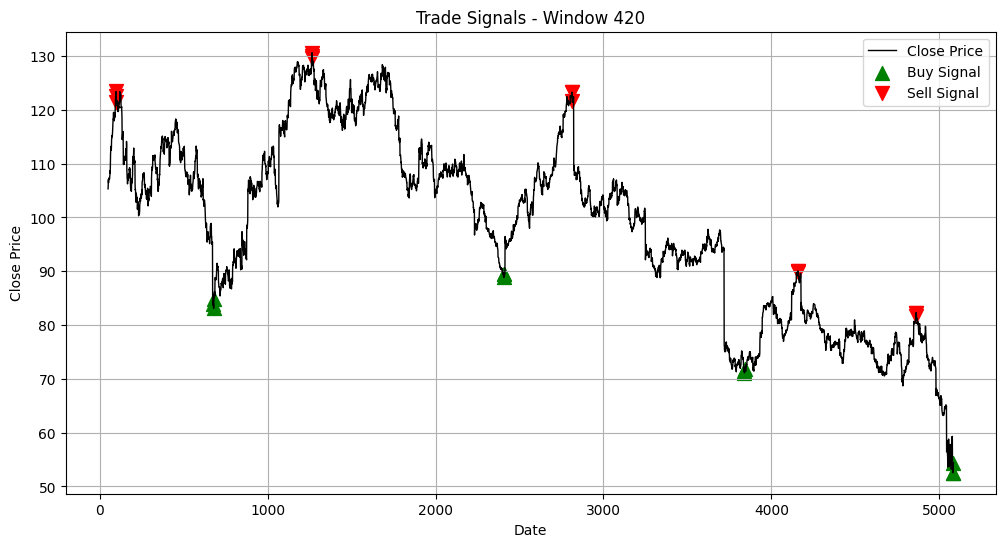

In [414]:
def plot_trade_signals(data, windows=[14,21,35, 70, 140, 420]):
    """
    Genera una gráfica por cada ventana de tiempo mostrando los buy y sell signals.
    """
    for window in windows:
        buy_col = f"buy_signal_w{window}"
        sell_col = f"sell_signal_w{window}"

        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data["Close"], label="Close Price", color="black", linewidth=1)

        # Puntos de compra (verde)
        buy_signals = data[data[buy_col] == 1]
        plt.scatter(buy_signals.index, buy_signals["Close"], color="green", marker="^", label="Buy Signal", s=100)

        # Puntos de venta (rojo)
        sell_signals = data[data[sell_col] == 1]
        plt.scatter(sell_signals.index, sell_signals["Close"], color="red", marker="v", label="Sell Signal", s=100)

        plt.title(f"Trade Signals - Window {window}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True)
        plt.show()

# Llamar a la función para graficar
plot_trade_signals(data_2w, windows=[14,21,35, 70, 140, 420])

In [415]:
# Calcular la matriz de correlación
correlation_matrix = data_2w.corr()
# 🔹 Obtener las variables con correlación débil con 'Future_Class_1w'
low_corr_features = correlation_matrix.index[
    correlation_matrix["Future_Class_1w"].between(-0.12, 0.12)
].difference(["Date", "Close"])

print(low_corr_features)

Index(['ADX', 'ADX_change_1w', 'ADX_change_2w', 'ATR', 'BBW', 'BB_lower',
       'BB_upper', 'CMF', 'Cumulative_Return', 'Day', 'Dia_de_la_Semana',
       'Dia_del_Año', 'EMA12', 'EMA26', 'EMA50', 'High', 'Hour',
       'Hourly_Return', 'Low', 'MACD', 'MACD_Signal', 'MOM', 'Month', 'OBV',
       'Open', 'Past_Change_1d', 'Past_Change_1m', 'Past_Change_1w',
       'Past_Change_2d', 'Past_Change_2m', 'Past_Change_2w', 'Past_Change_3m',
       'Past_Change_6m', 'Past_Class_1m', 'Past_Class_1w', 'Past_Class_2w',
       'Past_Class_3m', 'Past_Class_6m', 'Period_Trend_6m', 'RSI',
       'RSI_change_1w', 'RSI_change_2w', 'SMA50', 'Stoch_D', 'Stoch_K',
       'Vol_Ratio_10h', 'Volatility_Spike_H', 'Volatility_Spike_H_m',
       'Volatility_Spike_I', 'Volatility_Spike_I_m', 'Volatility_Spike_VH',
       'Volume', 'Volume_MA', 'Volume_MA_change_1w', 'Volumen_Color_Num',
       'Year', 'buy_signal_w140', 'buy_signal_w420', 'sell_signal_w14',
       'sell_signal_w140', 'sell_signal_w35', 'sell_sig

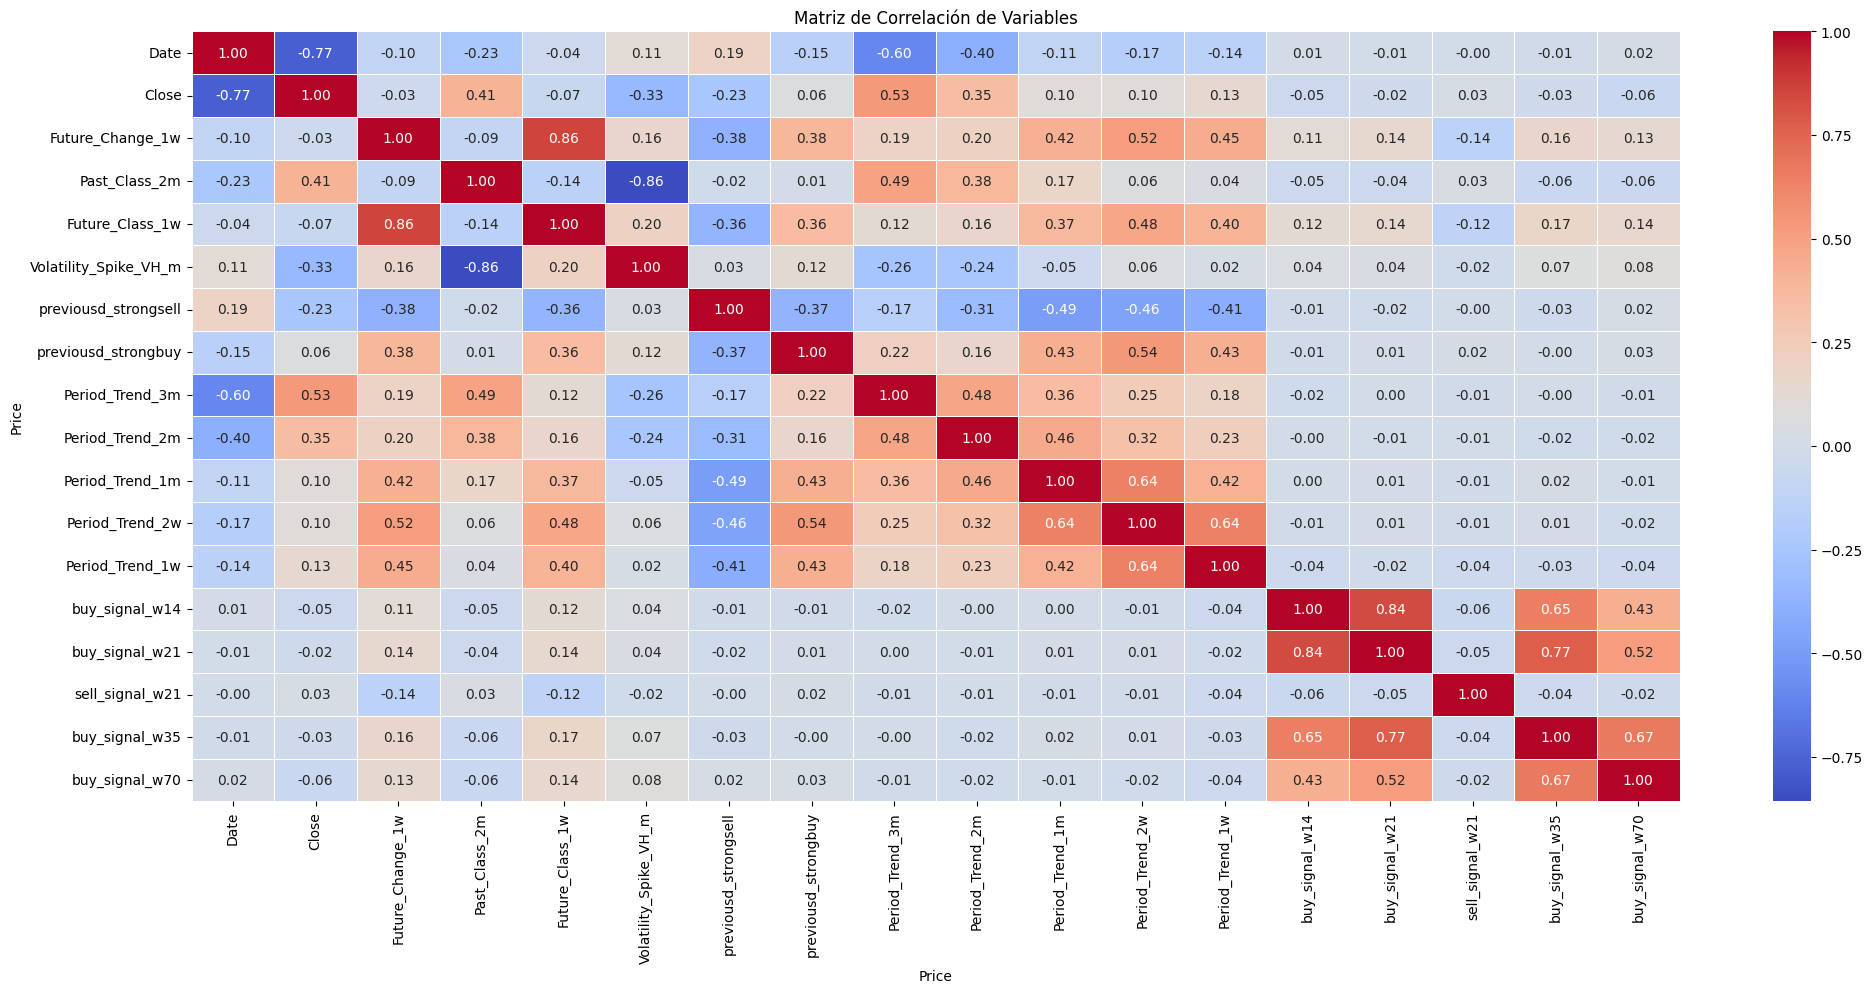

In [416]:
import seaborn as sns
# 📌 Eliminar las columnas con baja correlación
data_view = data_2w.drop(columns=data_2w[low_corr_features])

correlation_matrix = data_view.corr()

# Configurar la figura
plt.figure(figsize=(24, 10))

# Crear un heatmap con Seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título del gráfico
plt.title("Matriz de Correlación de Variables")

# Mostrar la gráfica
plt.show()

In [417]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Eliminar valores nulos
data_train_2w = data_2w.dropna()

# Preparar los datos
X = data_train_2w.drop(columns=["Future_Change_1w", "Future_Class_1w", "Date"])
y = data_train_2w["Future_Class_1w"]

# Normalización de las características usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled_2w = scaler.fit_transform(X)

# Definir la fecha de corte (por ejemplo, 2024-01-01)
fecha_corte = "2024-05-01"

# Crear el conjunto de entrenamiento (hasta la fecha de corte)
train_data = data_train_2w[data_train_2w["Date"] < fecha_corte]
test_data = data_train_2w[data_train_2w["Date"] >= fecha_corte]

# Preparar los datos de entrenamiento y prueba
X_train_2w = train_data.drop(columns=["Future_Change_1w", "Future_Class_1w", "Date"])
y_train_2w = train_data["Future_Class_1w"]
X_test_2w = test_data.drop(columns=["Future_Change_1w", "Future_Class_1w", "Date"])
y_test_2w = test_data["Future_Class_1w"]

smote = SMOTE(random_state=42)
X_train_2w, y_train_2w = smote.fit_resample(X_train_2w, y_train_2w)

# Inicializar los modelos optimizados
models = {
    # "Random Forest": RandomForestClassifier(
    #     n_estimators=1000,        # Más árboles para estabilidad
    #     max_depth=15,             # Mayor profundidad para capturar patrones complejos
    #     min_samples_split=5,      # Controlar sobreajuste
    #     min_samples_leaf=3,       # Evitar sobreajuste con hojas pequeñas
    #     max_features="sqrt",      # Mejor selección de características
    #     random_state=42,
    #     n_jobs=-1,
    # ),
    "XGBoost": xgb.XGBClassifier(
        objective="multi:softmax",  # Clasificación multiclase
        num_class=3,
        eval_metric="mlogloss",
        n_estimators=700,          # Aumentar iteraciones con tasa de aprendizaje menor
        learning_rate=0.005,        # Reducir tasa de aprendizaje para evitar sobreajuste
        max_depth=8,                # Más profundidad para captar patrones complejos
        subsample=0.9,              # Más muestreo para mejor generalización
        colsample_bytree=0.9,       # Más columnas en cada árbol
        gamma=0.2,                  # Control de regularización
        min_child_weight=4,         # Evitar que aprenda ruido
        reg_lambda=2,               # Mayor regularización L2
        random_state=42,
        n_jobs=-1,
    ),
    # "Gradient Boosting": GradientBoostingClassifier(
    #     n_estimators=700,        # Más iteraciones
    #     learning_rate=0.005,     # Aprendizaje más lento para estabilidad
    #     max_depth=7,             # Mayor profundidad
    #     min_samples_split=8,     # Evitar sobreajuste
    #     min_samples_leaf=4,      # Mantener estabilidad
    #     subsample=0.85,          # Más muestreo
    #     random_state=42,
    # ),
    "LightGBM": lgb.LGBMClassifier(
        objective="multiclass",
        num_class=3,
        n_estimators=800,       # Más iteraciones
        learning_rate=0.006,    # Más estabilidad
        max_depth=-1,           # Sin límite de profundidad
        num_leaves=40,          # Más hojas para captar patrones
        min_child_samples=15,   # Controlar sobreajuste
        subsample=0.85,         # Mejor generalización
        colsample_bytree=0.9,   # Más columnas en cada árbol
        reg_lambda=1.5,         # Regularización
        force_col_wise=True,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    ),
}

c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [418]:
# Entrenar y evaluar cada modelo
predictions_2w = {}
model_metrics = {}

for name, model in models.items():
    print(f"Entrenando modelo: {name}")

    # Entrenar el modelo con el conjunto de entrenamiento completo
    model.fit(X_train_2w, y_train_2w)

    # Hacer predicciones sobre el conjunto de prueba
    y_pred = model.predict(X_test_2w)

    # Guardar predicciones y métricas
    predictions_2w[name] = y_pred
    report_2w = classification_report(
        y_test_2w, y_pred, output_dict=True, zero_division=1
    )
    model_metrics[name] = report_2w

# Imprimir los resultados
for name, metrics in model_metrics.items():
    print(f"\nReporte de clasificación para el modelo: {name}")
    print(metrics)

Entrenando modelo: XGBoost
Entrenando modelo: LightGBM

Reporte de clasificación para el modelo: XGBoost
{'0': {'precision': 0.5081081081081081, 'recall': 0.4382284382284382, 'f1-score': 0.47058823529411764, 'support': 429.0}, '1': {'precision': 0.5994277539341917, 'recall': 0.5042117930204573, 'f1-score': 0.5477124183006536, 'support': 831.0}, '2': {'precision': 0.39042357274401474, 'recall': 0.6022727272727273, 'f1-score': 0.47374301675977654, 'support': 352.0}, 'accuracy': 0.5080645161290323, 'macro avg': {'precision': 0.4993198115954381, 'recall': 0.5149043195072076, 'f1-score': 0.49734789011818253, 'support': 1612.0}, 'weighted avg': {'precision': 0.5294863148285266, 'recall': 0.5080645161290323, 'f1-score': 0.5110353067298145, 'support': 1612.0}}

Reporte de clasificación para el modelo: LightGBM
{'0': {'precision': 0.5290519877675841, 'recall': 0.40326340326340326, 'f1-score': 0.4576719576719577, 'support': 429.0}, '1': {'precision': 0.5495867768595041, 'recall': 0.4801444043321

In [419]:
import json

# Guardar métricas en un archivo JSON
with open("model_metrics.json", "w") as f:
    json.dump(model_metrics, f, indent=4)

In [420]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

# Evaluar modelos con Accuracy, F1-score y Kappa
model_scores_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    accuracy = accuracy_score(y_test_2w, y_pred_2w)
    f1 = f1_score(y_test_2w, y_pred_2w, average="weighted")  # F1 ponderado
    kappa = cohen_kappa_score(y_test_2w, y_pred_2w)  # Cohen's Kappa

    model_scores_2w[model_name] = {"accuracy": accuracy, "f1_score": f1, "kappa": kappa}

# Ordenar modelos por precisión (puedes cambiar a 'f1_score' o 'kappa' si prefieres)
sorted_models_2w = sorted(
    model_scores_2w.items(), key=lambda x: x[1]["accuracy"], reverse=True
)

# Imprimir los 3 mejores modelos
print("🔹 Top 3 Modelos Basados en Precisión:")
for i, (model_name, scores) in enumerate(sorted_models_2w[:3]):
    print(f"{i + 1}. {model_name} - Precisión: {scores['accuracy']:.4f} | F1-Score: {scores['f1_score']:.4f} | Kappa: {scores['kappa']:.4f}")

🔹 Top 3 Modelos Basados en Precisión:
1. XGBoost - Precisión: 0.5081 | F1-Score: 0.5110 | Kappa: 0.2335
2. LightGBM - Precisión: 0.4795 | F1-Score: 0.4824 | Kappa: 0.1844


<Figure size 1000x600 with 0 Axes>

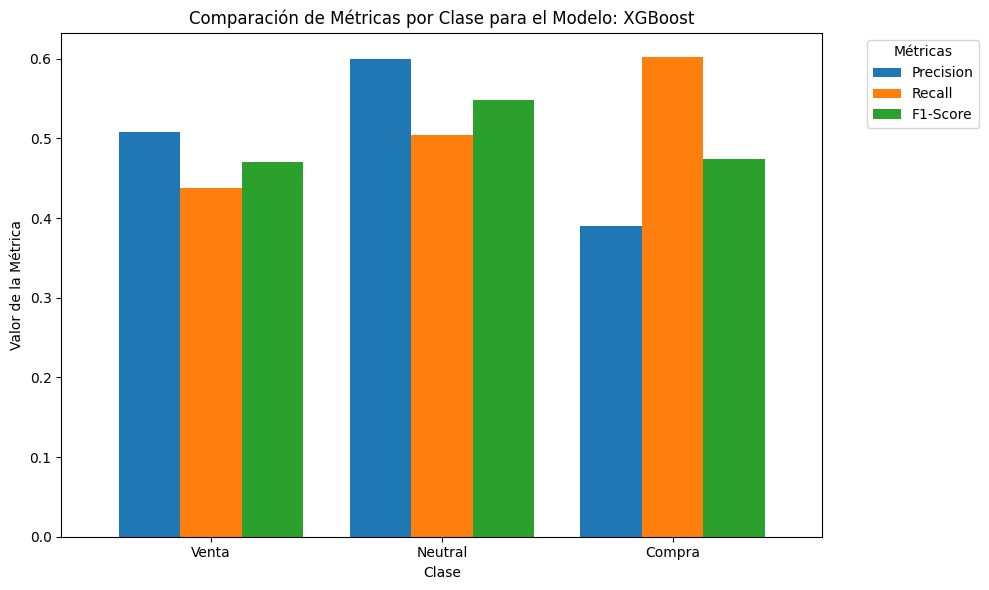

<Figure size 1000x600 with 0 Axes>

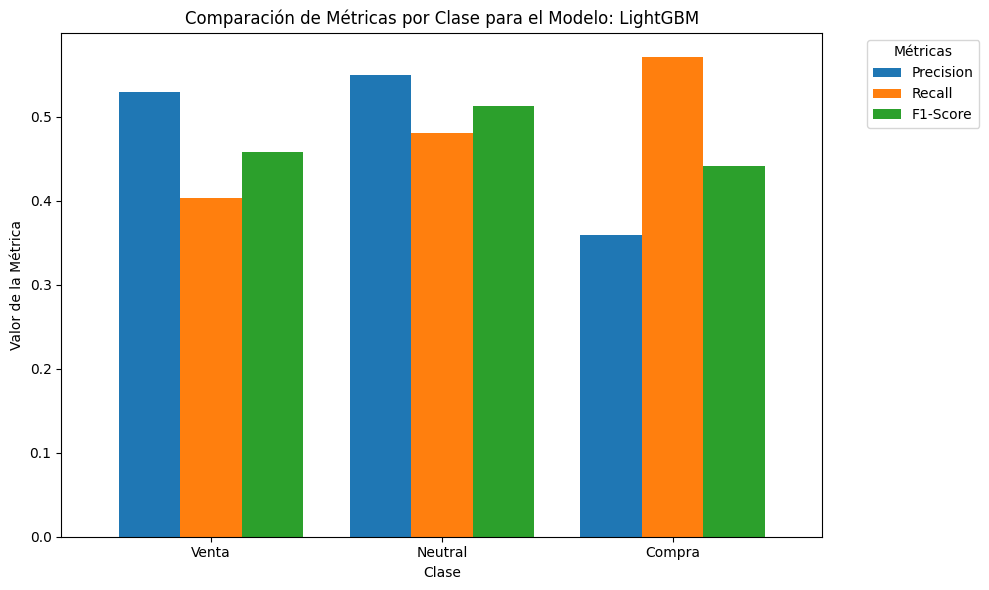

In [421]:
# Crear un DataFrame vacío para almacenar las métricas por clase
class_metrics = {}

# Definir el diccionario para mapear las etiquetas numéricas a las de clase
label_mapping = {
    0: "Venta",
    1: "Neutral",
    2: "Compra"
}

# Extraer las métricas por clase para cada modelo
for model_name, y_pred_2w in predictions_2w.items():
    # Obtener el reporte de clasificación por clase
    report_2w = classification_report(y_test_2w, y_pred_2w, output_dict=True, zero_division=1)
    
    # Filtrar las métricas relevantes (precision, recall, f1-score) para cada clase
    for label in ['0', '1', '2']:  # 0: Venta, 1: Neutral, 2: Compra
        class_label = label_mapping[int(label)]  # Convertir el número a la etiqueta correspondiente
        class_metrics.setdefault(model_name, {})[class_label] = {
            "Precision": report_2w[label]['precision'],
            "Recall": report_2w[label]['recall'],
            "F1-Score": report_2w[label]['f1-score']
        }

# Crear una gráfica para cada modelo
for model_name, metrics in class_metrics.items():
    # Convertir las métricas por clase a un DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

    # Crear una figura para el gráfico
    plt.figure(figsize=(10, 6))

    # Graficar las métricas de precisión, recall y f1-score por clase para el modelo actual
    metrics_df.plot(kind='bar', figsize=(10, 6), width=0.8)

    # Añadir título y etiquetas
    plt.title(f'Comparación de Métricas por Clase para el Modelo: {model_name}')
    plt.xlabel('Clase')
    plt.ylabel('Valor de la Métrica')
    plt.xticks(rotation=0)  # No rotar las etiquetas para que se vean bien
    plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajustar la visualización del gráfico para que todo se vea bien
    plt.tight_layout()

    # Mostrar la gráfica
    plt.show()

In [422]:
# Mostrar la cantidad de cada predicción por modelo
prediction_counts_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    unique, counts = np.unique(y_pred_2w, return_counts=True)  # Contar la frecuencia de cada predicción
    prediction_counts_2w[model_name] = dict(zip(unique, counts))

In [423]:
# Crear un DataFrame para almacenar las predicciones y los valores reales
comparison_df_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    # Crear un DataFrame con las predicciones y las clases reales
    comparison_df_2w[model_name] = pd.DataFrame(
        {
            "Real": y_test_2w,  # Valores reales
            "Predicción": y_pred_2w,  # Predicciones del modelo
        }
    )

In [424]:
print(comparison_df_2w[model_name])

      Real  Predicción
3439     2           1
3440     2           1
3441     2           1
3442     2           1
3443     2           1
...    ...         ...
5046     0           1
5047     0           1
5048     0           2
5049     0           2
5050     1           2

[1612 rows x 2 columns]


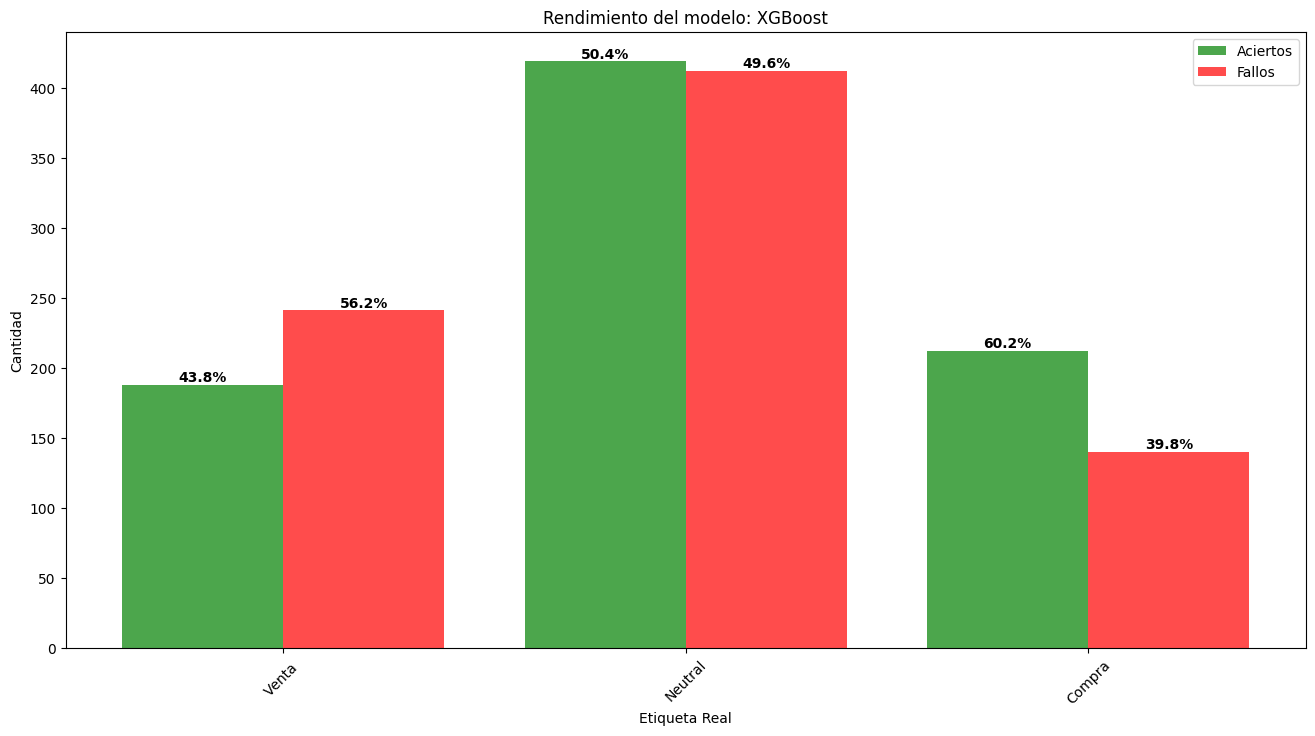

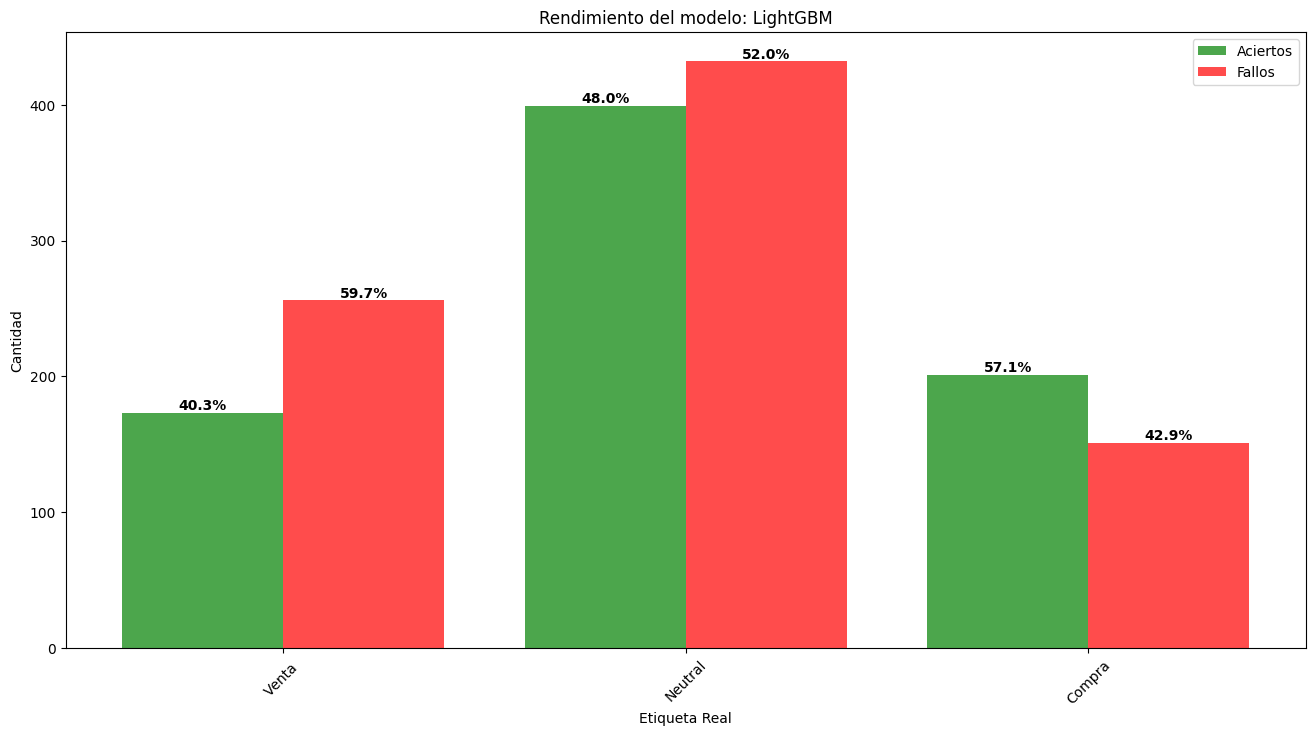

In [425]:
# 🔹 Diccionario para mapear números a etiquetas (con orden específico)
label_mapping = {
    0: "Venta ",
    1: "Neutral",
    2: "Compra",
}

# Lista ordenada de etiquetas
ordered_labels = list(label_mapping.values())

# 🔹 Crear un DataFrame para almacenar las comparaciones
comparison_df_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    # Crear DataFrame con valores reales y predicciones
    df = pd.DataFrame({"Real": y_test_2w, "Predicción": y_pred_2w})

    # Convertir los valores numéricos a etiquetas de texto
    df["Real"] = df["Real"].map(label_mapping)
    df["Predicción"] = df["Predicción"].map(label_mapping)

    # Definir el orden de las categorías para "Real" y "Predicción"
    df["Real"] = pd.Categorical(df["Real"], categories=ordered_labels, ordered=True)
    df["Predicción"] = pd.Categorical(df["Predicción"], categories=ordered_labels, ordered=True)

    # Guardar en el diccionario
    comparison_df_2w[model_name] = df

# 🔹 Crear una gráfica para comparar aciertos y errores por cada etiqueta
for model_name, df in comparison_df_2w.items():
    df["Correcto"] = df["Real"] == df["Predicción"]  # True si acertó, False si falló

    # Contar aciertos y errores por etiqueta
    results = (df.groupby(["Real", "Correcto"], observed=False).size().unstack(fill_value=0))

    # Asegurar que las columnas existen y renombrarlas si es necesario
    results = results.rename(columns={True: "Aciertos", False: "Fallos"})

    # Si faltan columnas, agregarlas con 0
    results = results.reindex(columns=["Aciertos", "Fallos"], fill_value=0)

    # Calcular porcentajes
    total_counts = results.sum(axis=1)
    percentages = results.div(total_counts, axis=0) * 100  # Convertir a porcentaje

    # 🔹 Gráfica con barras separadas (verde a la izquierda, roja a la derecha)
    x = np.arange(len(ordered_labels))  # Posiciones de las etiquetas
    width = 0.4  # Ancho de las barras

    plt.figure(figsize=(16, 8))

    # Barras de aciertos (izquierda)
    bars1 = plt.bar(
        x - width / 2,
        results["Aciertos"],
        width=width,
        color="green",
        alpha=0.7,
        label="Aciertos",
    )

    # Barras de fallos (derecha)
    bars2 = plt.bar(
        x + width / 2,
        results["Fallos"],
        width=width,
        color="red",
        alpha=0.7,
        label="Fallos",
    )

    # 🔹 Añadir los porcentajes sobre cada barra
    for bar, pct1 in zip(bars1, percentages["Aciertos"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{pct1:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    for bar, pct2 in zip(bars2, percentages["Fallos"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{pct2:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # 🔹 Formato final de la gráfica
    plt.title(f"Rendimiento del modelo: {model_name}")
    plt.xlabel("Etiqueta Real")
    plt.ylabel("Cantidad")
    plt.xticks(x, ordered_labels, rotation=45)  # Etiquetas con rotación
    plt.legend()
    plt.show()

In [426]:
# Obtener los datos de ayer (última fila)
yesterday_data = data_2w.iloc[-1:]

# Extraer fecha y precio de cierre de ayer
yesterday_date = yesterday_data["Date"].values[0]
yesterday_close = yesterday_data["Close"].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday = yesterday_data.drop(columns=["Future_Change_1w", "Future_Class_1w", "Date"])
X_yesterday_np = (X_yesterday.to_numpy())  # Convertir a numpy para evitar warnings de Scikit-Learn

# Hacer predicciones con cada modelo
future_predictions = {}

for model_name, model in models.items():
    future_prediction = model.predict(X_yesterday_np)[0]  # Obtener la predicción numérica

    future_predictions[model_name] = (
        f"📉 Caída (< {percentiles_2w[0]:.2f}%)"
        if future_prediction == 0
        else (
            f"➖  Sin cambios significativos ({percentiles_2w[0]:.2f}% a {percentiles_2w[1]:.2f}%)"
            if future_prediction == 1
            else (f"🚀 Compra (>{percentiles_2w[1]:.2f}%)")
        )
    )

# Mostrar los resultados con fecha formateada correctamente
print(f"\n📅 Fecha de la última observación: {pd.to_datetime(yesterday_date).strftime('%Y-%m-%d %H:%M')}")
print(f"💰 Precio de cierre: {yesterday_close:.2f} USD\n")

print("🔮 Predicciones de 'Future_Class_1w' para los datos de ayer:")
for model_name, prediction in future_predictions.items():
    print(f"⚡ {model_name}: {prediction}")


📅 Fecha de la última observación: 2025-04-10 19:30
💰 Precio de cierre: 54.40 USD

🔮 Predicciones de 'Future_Class_1w' para los datos de ayer:
⚡ XGBoost: 🚀 Compra (>2.43%)
⚡ LightGBM: ➖  Sin cambios significativos (-3.61% a 2.43%)


c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


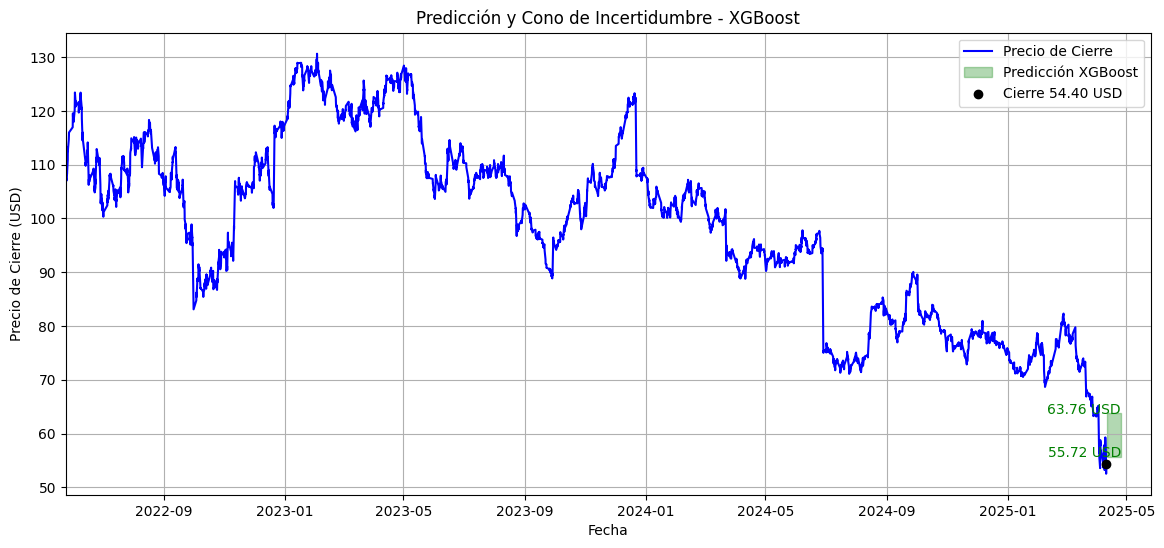

(2.4297571477350863, 17.213835435692246)


c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


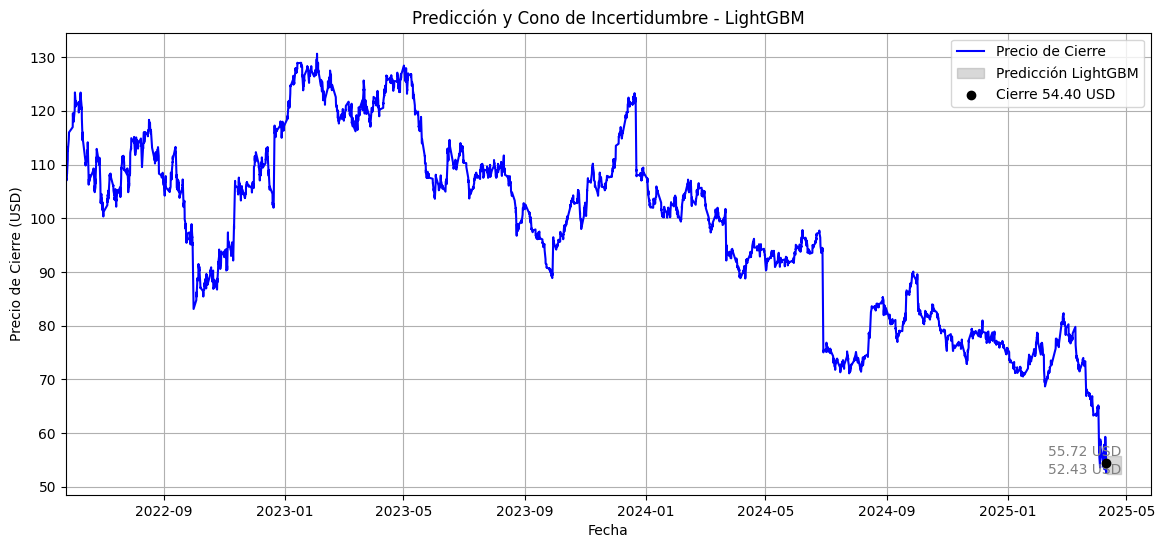

(-3.6133905211033963, 2.4297571477350863)


In [427]:
min_change = abs(data_2w['Past_Change_1w'].min())  # Valor absoluto del mínimo
max_change = abs(data_2w['Past_Change_1w'].max())  # Valor absoluto del máximo

# Función para mostrar la predicción con un cono
def plot_prediction_cone(data, model_name, X_yesterday_np, yesterday_close, yesterday_date, percentiles_2w, model, cone_width=10):
    # Obtener la predicción del modelo para el último día
    future_prediction = model.predict(X_yesterday_np)[0]
    
    # Definir el rango de la predicción basado en los percentiles
    if future_prediction == 0:  # Caída
        color = "red"
        pred_range = (percentiles_2w[0]- abs(min_change),percentiles_2w[0])
    elif future_prediction == 1:  # Sin cambios
        color = "gray"
        pred_range = (percentiles_2w[0], percentiles_2w[1])
    else:  # Subida
        color = "green"
        pred_range = (percentiles_2w[1], percentiles_2w[1] + abs(max_change))  # Ajustar este valor si es necesario

    # Calcular los precios proyectados
    lower_bound = yesterday_close * (1 + (pred_range[0] / 100))
    upper_bound = yesterday_close * (1 + (pred_range[1] / 100))

    # Crear la gráfica
    future_dates = pd.date_range(start=yesterday_date, periods=cone_width + 1, freq='D')[1:]  # Aumentamos el rango de fechas

    # Graficar el historial de precios de cierre
    plt.figure(figsize=(14, 6))
    plt.plot(
        data.iloc[:]["Date"],
        data.iloc[:]["Close"],
        label="Precio de Cierre",
        color="blue",
    )

    # Graficar el cono de predicción con mayor "ancho"
    lower_bound = np.array([lower_bound] * len(future_dates))  # Asegura que todos los valores sean consistentes en longitud
    upper_bound = np.array([upper_bound] * len(future_dates))

    plt.fill_between(
        future_dates,
        lower_bound,
        upper_bound,
        color=color,
        alpha=0.3,
        label=f"Predicción {model_name}",
    )

    # Etiquetas de los valores proyectados
    plt.text(
        future_dates[-1],
        lower_bound[-1],
        f"{lower_bound[-1]:.2f} USD",
        color=color,
        fontsize=10,
        ha="right",
    )
    plt.text(
        future_dates[-1],
        upper_bound[-1],
        f"{upper_bound[-1]:.2f} USD",
        color=color,
        fontsize=10,
        ha="right",
    )

    # Marcar el punto de inicio (último día) y el cierre futuro proyectado
    plt.scatter(
        yesterday_date,
        yesterday_close,
        color="black",
        zorder=3,
        label=f"Cierre {yesterday_close:.2f} USD",
    )

    # Configuración del gráfico
    plt.xlabel("Fecha")
    plt.ylabel("Precio de Cierre (USD)")
    plt.title(f"Predicción y Cono de Incertidumbre - {model_name}")
    plt.legend()
    plt.grid(True)

    plt.xlim(data["Date"].min(), future_dates[-1] + pd.Timedelta(days=30))
    plt.show()
    
    print(pred_range)


# Obtener los datos del último día
yesterday_data = data_2w.iloc[-1:]

# Extraer fecha y precio de cierre de ayer
yesterday_date = yesterday_data["Date"].values[0]
yesterday_close = yesterday_data["Close"].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday = yesterday_data.drop(columns=["Future_Change_1w", "Future_Class_1w", "Date"])
X_yesterday_np = X_yesterday.to_numpy()  # Convertir a numpy para evitar warnings de Scikit-Learn

# Graficar las predicciones con conos para cada modelo
for model_name, model in models.items():
    plot_prediction_cone(data_2w, model_name, X_yesterday_np, yesterday_close, yesterday_date, percentiles_2w, model, cone_width=15)


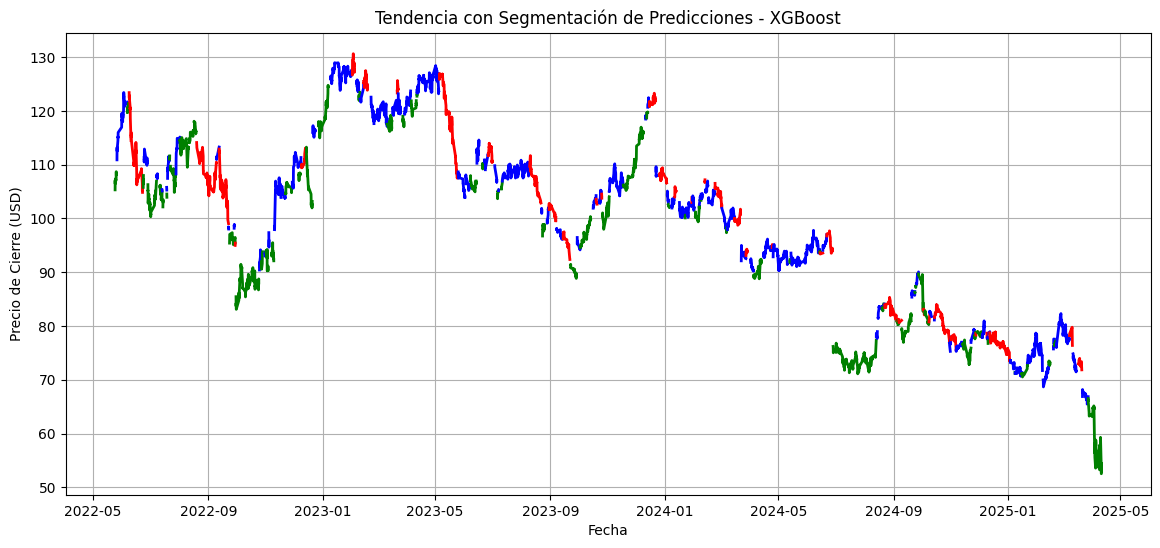

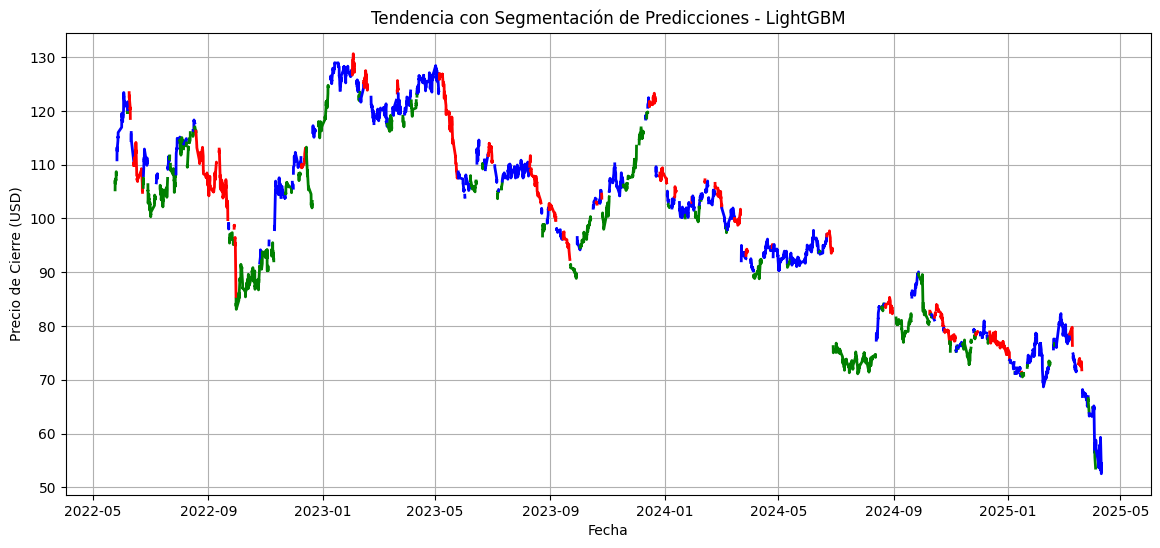

In [428]:
import matplotlib.pyplot as plt

def plot_colored_trend(data, predictions, model_name, threshold=3):
    """
    Grafica el precio de cierre con segmentos de color según las predicciones.
    
    Parámetros:
    - data: DataFrame con las columnas "Date" y "Close".
    - predictions: Lista o Serie con las predicciones del modelo.
    - model_name: Nombre del modelo para el título de la gráfica.
    - threshold: Número mínimo de predicciones consecutivas para colorear.
    """
    plt.figure(figsize=(14, 6))
    
    # Variables para controlar los segmentos de color
    prev_pred = predictions[0]
    segment_dates = [data["Date"].iloc[0]]
    segment_prices = [data["Close"].iloc[0]]

    for i in range(1, len(predictions)):
        if predictions[i] == prev_pred:
            segment_dates.append(data["Date"].iloc[i])
            segment_prices.append(data["Close"].iloc[i])
        else:
            # Determinar color del segmento
            if len(segment_dates) >= threshold:
                if prev_pred == 0:
                    color = "red"  # Caída
                elif prev_pred == 2:
                    color = "green"  # Subida
                else:
                    color = "blue"  # Sin señal fuerte
                plt.plot(segment_dates, segment_prices, color=color, linewidth=2)
            
            # Reiniciar segmento
            segment_dates = [data["Date"].iloc[i]]
            segment_prices = [data["Close"].iloc[i]]
            prev_pred = predictions[i]
    
    # Dibujar el último segmento
    if len(segment_dates) >= threshold:
        if prev_pred == 0:
            color = "red"
        elif prev_pred == 2:
            color = "green"
        else:
            color = "blue"
        plt.plot(segment_dates, segment_prices, color=color, linewidth=2)

    # Configuración de la gráfica
    plt.xlabel("Fecha")
    plt.ylabel("Precio de Cierre (USD)")
    plt.title(f"Tendencia con Segmentación de Predicciones - {model_name}")
    plt.grid(True)
    plt.show()

# Generar predicciones para cada modelo y graficar
for model_name, model in models.items():
    # Eliminar NaN reemplazándolos con la media o eliminando filas
    X_input = data_2w.drop(columns=["Future_Change_1w", "Future_Class_1w", "Date"]).copy()
    
    # Opciones para manejar NaN:
    X_input = X_input.fillna(X_input.mean())  # Reemplazar NaN con la media de cada columna
    # X_input = X_input.dropna()  # También se pueden eliminar las filas con NaN
    
    predictions = model.predict(X_input)
    plot_colored_trend(data_2w, predictions, model_name, threshold=3)



In [429]:
import matplotlib.pyplot as plt

# Últimos 350 registros para graficar historial
data_last_350 = data_2w.tail(500)

# Obtener datos de ayer (última fila)
yesterday_data_2w = data_2w.iloc[-1:]
yesterday_date_2w = yesterday_data_2w["Date"].values[0]
yesterday_close_2w = yesterday_data_2w["Close"].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday_2w = yesterday_data.drop(
    columns=["Future_Change_1w", "Future_Class_1w", "Date"]
)
X_yesterday_2w_np = X_yesterday.to_numpy()

# Definir cuántos pasos futuros extenderemos la banda
future_steps_2w = 70
last_date = data_last_350["Date"].max()  # Última fecha en la data histórica
future_dates_2w = pd.date_range(start=last_date, periods=future_steps_2w + 1, freq="h")[
    1:
]

c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📅 Fecha evaluada: 2025-04-03 19:30:00
💰 Cierre en la fecha evaluada: 55.56 USD
📅 Fecha futura (2 semanas después): 2025-04-10 19:30:00
💰 Cierre en la fecha futura: 54.40 USD
📈 Cambio real en porcentaje: -2.09%

🔍 Predicciones de los modelos y precios proyectados:
XGBoost: Predicción = 2 | Rango esperado = 56.91 - 65.12 USD
🎯 Rango de percentiles: 2.43% - 17.21% -> ❌ No acertó.
LightGBM: Predicción = 2 | Rango esperado = 56.91 - 65.12 USD
🎯 Rango de percentiles: 2.43% - 17.21% -> ❌ No acertó.


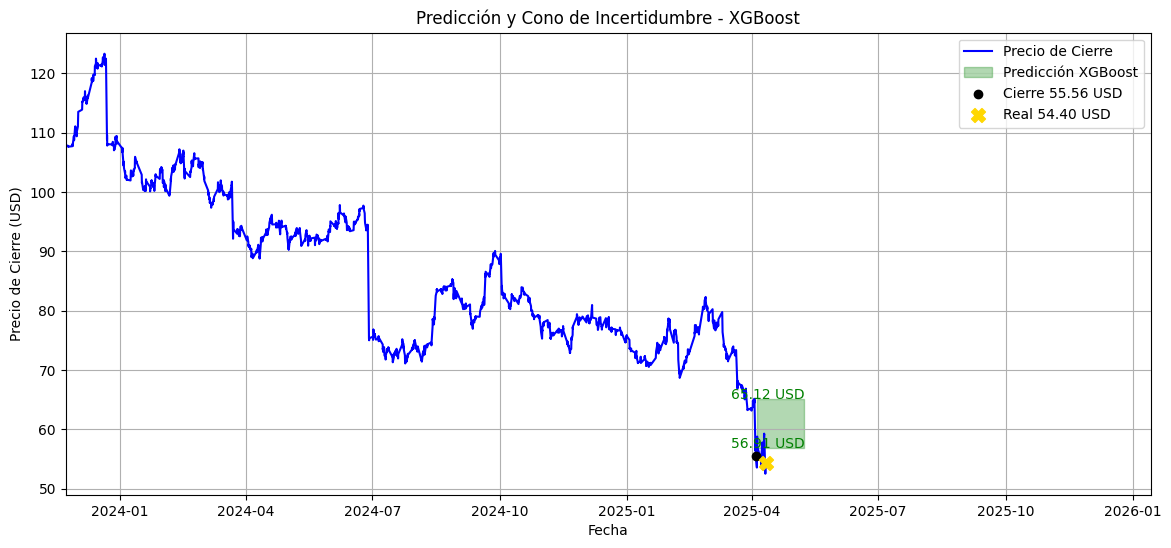

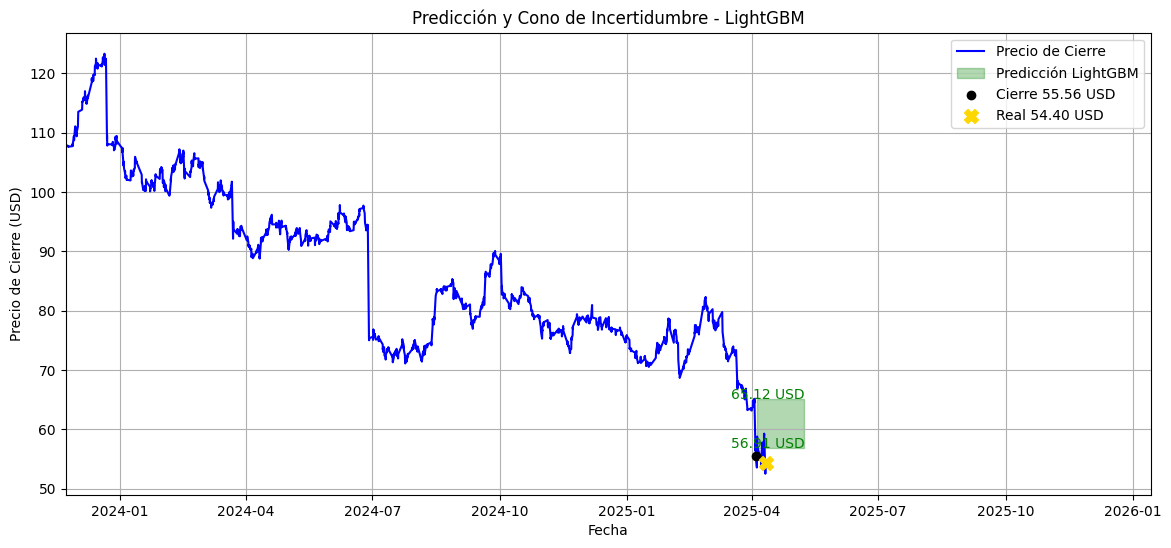

In [430]:
def check_prediction_with_cone(data, x, periods_ahead=70, num_days_to_plot=200):
    if -x >= len(data) or -x + periods_ahead >= len(data):
        print(f"⚠️ No hay suficientes datos para verificar {x} períodos atrás.")
        return

    # 🔹 Obtener datos del punto de partida
    specific_day_data = data.iloc[-x]
    specific_date = specific_day_data["Date"]
    close_actual = specific_day_data["Close"]
    
    min_change = abs(data_2w['Past_Change_1w'].min())  # Valor absoluto del mínimo
    max_change = abs(data_2w['Past_Change_1w'].max())  # Valor absoluto del máximo

    # 🔹 Obtener datos del punto futuro donde se verificará la predicción
    future_day_data = data.iloc[-x + periods_ahead]
    future_date = future_day_data["Date"]
    close_future = future_day_data["Close"]

    # 🔹 Calcular el cambio real en porcentaje
    real_change_percent = ((close_future - close_actual) / close_actual) * 100

    # 🔹 Extraer características para la predicción
    features = [
        col
        for col in data.columns
        if col not in ["Future_Change_1w", "Future_Class_1w", "Date"]
    ]
    X_specific_day = specific_day_data[features]

    specific_day_predictions = {}
    projected_prices = {}

    for model_name, model in models.items():
        future_prediction = int(model.predict([X_specific_day])[0])
        specific_day_predictions[model_name] = future_prediction

        # 🔹 Determinar el rango según la predicción
        if future_prediction == 0:  # Caída muy fuerte
            color = "red"
            pred_range = (percentiles_2w[0] - min_change, percentiles_2w[0])
        elif future_prediction == 1:  # Caída moderada
            color = "orangered"
            pred_range = (percentiles_2w[0], percentiles_2w[1])
        else:  # Subida muy fuerte
            color = "green"
            pred_range = (percentiles_2w[1], percentiles_2w[1] + max_change)

        projected_price_min = close_actual * (1 + (pred_range[0] / 100))
        projected_price_max = close_actual * (1 + (pred_range[1] / 100))
        projected_prices[model_name] = (
            projected_price_min,
            projected_price_max,
            pred_range[0],
            pred_range[1],
        )

    # 📌 Mostrar resultados
    print(f"\n📅 Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha evaluada: {close_actual:.2f} USD")
    print(f"📅 Fecha futura (2 semanas después): {future_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha futura: {close_future:.2f} USD")
    print(f"📈 Cambio real en porcentaje: {real_change_percent:.2f}%")

    print("\n🔍 Predicciones de los modelos y precios proyectados:")
    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, percentile_min, percentile_max = projected_prices[model_name]

        if percentile_min <= real_change_percent <= percentile_max:
            resultado = "✅ Acertó!"
        else:
            resultado = "❌ No acertó."

        print(f"{model_name}: Predicción = {prediction} | Rango esperado = {price_min:.2f} - {price_max:.2f} USD")
        print(f"🎯 Rango de percentiles: {percentile_min:.2f}% - {percentile_max:.2f}% -> {resultado}")

    # 🚀 Graficar con el cono de predicción (una gráfica por modelo)
    future_steps = periods_ahead
    future_dates = pd.date_range(start=specific_date, periods=future_steps + 1, freq="D")[1:]

    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, _, _ = projected_prices[model_name]

        # 🔹 Graficar el historial del precio de cierre
        plt.figure(figsize=(14, 6))
        plt.plot(
            data.iloc[-num_days_to_plot:]["Date"],
            data.iloc[-num_days_to_plot:]["Close"],
            label="Precio de Cierre",
            color="blue",
        )

        # 🔹 Graficar el cono de predicción
        lower_bound = [
            close_actual * (1 + (projected_prices[model_name][2] / 100))
        ] * len(future_dates)
        upper_bound = [
            close_actual * (1 + (projected_prices[model_name][3] / 100))
        ] * len(future_dates)

        plt.fill_between(
            future_dates,
            lower_bound,
            upper_bound,
            color=color,
            alpha=0.3,
            label=f"Predicción {model_name}",
        )

        # 🔹 Etiquetas de los valores proyectados en el extremo derecho
        plt.text(
            future_dates[-1],
            lower_bound[-1],
            f"{lower_bound[-1]:.2f} USD",
            color=color,
            fontsize=10,
            ha="right",
        )
        plt.text(
            future_dates[-1],
            upper_bound[-1],
            f"{upper_bound[-1]:.2f} USD",
            color=color,
            fontsize=10,
            ha="right",
        )

        # 🔹 Marcar el punto de inicio de la predicción y el cierre real futuro
        plt.scatter(
            specific_date,
            close_actual,
            color="black",
            zorder=3,
            label=f"Cierre {close_actual:.2f} USD",
        )
        plt.scatter(
            future_date,
            close_future,
            color="gold",
            marker="X",
            s=100,
            zorder=4,
            label=f"Real {close_future:.2f} USD",
        )

        # Configuración del gráfico
        plt.xlabel("Fecha")
        plt.ylabel("Precio de Cierre (USD)")
        plt.title(f"Predicción y Cono de Incertidumbre - {model_name}")
        plt.legend()
        plt.grid(True)

        plt.xlim(
            data.iloc[-num_days_to_plot]["Date"],
            future_dates[-1] + pd.Timedelta(days=250),
        )
        plt.show()


# Llamada a la función con los parámetros deseados
check_prediction_with_cone(data_2w, x=36, periods_ahead=35, num_days_to_plot=2400)

In [431]:
# Seleccionar el mejor modelo para COMPRAR (basado en la precisión de la clase "1")
mejor_modelo_compra = models[max(model_metrics, key=lambda k: model_metrics[k]["2"]["precision"])]
print(f"\nMejor modelo para comprar: {mejor_modelo_compra}")

# Seleccionar el mejor modelo para VENDER (basado en la precisión de la clase "0")
mejor_modelo_venta = models[max(model_metrics, key=lambda k: model_metrics[k]["0"]["precision"])]
print(f"Mejor modelo para vender: {mejor_modelo_venta}")



Mejor modelo para comprar: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=700,
              n_jobs=-1, num_class=3, num_parallel_tree=None, ...)
Mejor modelo para vender: LGBMClassifier(colsample_bytree=0.9, force_col_wise=True, learning_rate=0.006,
               min_child_samples=15, n_estimators=800, n_jobs=-1, num_class=3,
               num_leaves=40, objective=